In [23]:
import os
import io
import csv
import time
import pickle
import pprint
from tqdm import tqdm
from multiprocessing import Manager, Process, Pool
from functools import partial
from itertools import compress, chain, repeat
from operator import itemgetter
import operator as op

from sklearn.preprocessing import normalize

import numpy as np
import pandas as pd
from PIL import Image
import cv2
from skimage.draw import polygon_perimeter
import matplotlib as mpl
# matplotlib.use('TkAgg')
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


import matplotlib.font_manager
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import entropy, norm, uniform
from torchvision import datasets, transforms

import faiss
from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues, find_predicted_neq_given, find_label_issues_using_argmax_confusion_matrix
from cleanlab.dataset import health_summary
from cleanlab.count import get_confident_thresholds, estimate_joint, compute_confident_joint, estimate_latent, estimate_noise_matrices, calibrate_confident_joint, estimate_py_and_noise_matrices_from_probabilities
from cleanlab.rank import get_label_quality_scores, get_normalized_margin_for_each_label, get_self_confidence_for_each_label, get_confidence_weighted_entropy_for_each_label
from cleanlab.internal.label_quality_utils import (
    _subtract_confident_thresholds,
    get_normalized_entropy,
)

from model import Net, GtsrbFolderWithPaths, SwedishFolderWithPaths


from id_to_class import coco_shiftall_det as id2class
from id_to_class import coco_shiftall_name2RGB as name2RGB
from id_to_class import coco_shiftall_name2white as name2white
from id_to_class import coco_shiftall_name2red as name2red


import torch
import gc
pp = pprint.PrettyPrinter(indent=4)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
pd.options.mode.chained_assignment = None  # default='warn'
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']


# Read SHIFT DataFrame (has true_label)

In [24]:

######################################
#                                  subset = shiftall
######################################
subset = 'shiftall'


######################################
#                                  subset = vehicle
######################################
# subset = 'vehicle'
# shift_vehicle = {
#     0: "car",
#     1: "truck",
#     2: "bus",
#     # 3: "pedestrian",
#     # 4: "motorcycle",
#     # 5: "bicycle"
# }
# id2class = shift_vehicle

######################################
#                                  subset = moto
######################################
# subset = 'moto'
# shift_moto = {
#     0: "pedestrian",
#     1: "motorcycle",
#     2: "bicycle"
#     # 3: "car",
#     # 4: "truck",
#     # 5: "bus",
# }
# id2class = shift_moto

# shift_moto = {
#     0: "pedestrian",
#     1: "motorcycle",
#     2: "bicycle"
#     # 3: "car",
#     # 4: "truck",
#     # 5: "bus",
# }

# shift_moto_map = {
#     0: 0, # original: pedestrian(0), new: pedestrian(0)
#     4: 1, # original: motorcycle(4), new: motorcycle(1)
#     5: 2, # original: bicycle(5), new: bicycle(2)
#     1: 3, # original: car(1), new: car(3)
#     2: 4, # original: truck(2), new: truck(4)
#     3: 5  # original: bus(3), new: bus(5)
# }

m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
# m_names = ['clean','uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']


# cog is slightly beter than ogc
coco_gdino_backbone = 'COCO_gdino_swint' # no coco pre-train
# coco_gdino_backbone = 'COCO_gdino_swinb' # with coco pre-train
source_csv_dirpath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}'
# source_csv_dirpath = d'./postprocessing/code/DataFrame/{coco_gdino_backbone}'
tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig'

In [25]:



def convert_csv2np(df, colnames):

    for col in colnames:
        df[col] = df[col].apply(lambda x: np.asarray(x.split(';'), dtype=float))

    return df


def read_df_with_truelabels(csv_filepath, colnames):

    
    df = pd.read_csv(csv_filepath, header=0, delimiter=',', index_col=0)
    df = convert_csv2np(df, colnames)
    df = df.assign(c_incorrect=df['label_gt_des'] != df['true_label_des'])


    for class_id, classname in id2class.items():
        df[classname] = df['prob'].apply(lambda x: x[class_id])

    return df

# val_ass10_box0.2_all.csv  val_ass5_box0.2_all.csv   val_uni1_box0.2_all.csv
# val_ass1_box0.2_all.csv   val_uni10_box0.2_all.csv  val_uni5_box0.2_all.csv

colnames = ['bbox_gt', 'class_logit', 'class_logit_raw', 'prob', 'prob_sig']


rounds = list(range(1, 6))
m_dic = {m: {int(r): None for r in rounds} for m in m_names}


for _, m_name in tqdm(enumerate(m_names)):
    for round_i in rounds:
        source_csv_filepath = f'{source_csv_dirpath}/{m_name}/{subset}_{m_name}_round{round_i}.csv'
        m_dic[m_name][int(round_i)] = read_df_with_truelabels(source_csv_filepath, colnames)
        print(f'{source_csv_filepath} is loaded')


0it [00:00, ?it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/uni20/shiftall_uni20_round1.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni20/shiftall_uni20_round2.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni20/shiftall_uni20_round3.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni20/shiftall_uni20_round4.csv is loaded


1it [00:00,  1.42it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/uni20/shiftall_uni20_round5.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni10/shiftall_uni10_round1.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni10/shiftall_uni10_round2.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni10/shiftall_uni10_round3.csv is loaded


2it [00:01,  1.43it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/uni10/shiftall_uni10_round4.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni10/shiftall_uni10_round5.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni5/shiftall_uni5_round1.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni5/shiftall_uni5_round2.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni5/shiftall_uni5_round3.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni5/shiftall_uni5_round4.csv is loaded


3it [00:02,  1.44it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/uni5/shiftall_uni5_round5.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni1/shiftall_uni1_round1.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni1/shiftall_uni1_round2.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni1/shiftall_uni1_round3.csv is loaded


4it [00:02,  1.43it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/uni1/shiftall_uni1_round4.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/uni1/shiftall_uni1_round5.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass20/shiftall_ass20_round1.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass20/shiftall_ass20_round2.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass20/shiftall_ass20_round3.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass20/shiftall_ass20_round4.csv is loaded


5it [00:03,  1.42it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/ass20/shiftall_ass20_round5.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass10/shiftall_ass10_round1.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass10/shiftall_ass10_round2.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass10/shiftall_ass10_round3.csv is loaded


6it [00:04,  1.43it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/ass10/shiftall_ass10_round4.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass10/shiftall_ass10_round5.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass5/shiftall_ass5_round1.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass5/shiftall_ass5_round2.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass5/shiftall_ass5_round3.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass5/shiftall_ass5_round4.csv is loaded


7it [00:04,  1.42it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/ass5/shiftall_ass5_round5.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass1/shiftall_ass1_round1.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass1/shiftall_ass1_round2.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass1/shiftall_ass1_round3.csv is loaded


8it [00:05,  1.42it/s]

./postprocessing/code/DataFrame/COCO_gdino_swint/ass1/shiftall_ass1_round4.csv is loaded
./postprocessing/code/DataFrame/COCO_gdino_swint/ass1/shiftall_ass1_round5.csv is loaded


# Model Performance

In [4]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from scipy.special import softmax

import math

def cls_to_probs(cls_scores):

    # print(f'[cls_to_probs] cls_score.shape={cls_score.shape}')

    probs = softmax(cls_scores, axis=1)
    # print('cls_score.shape=', cls_score.shape)
    # print(f'scores.shape={probs.shape}')
    # assert cls_scores.size(0) == gt_bboxes.size(0)

    # sanity check
    # close_to_1 = probs.sum(axis=1)
    # print(f'close_to_1={close_to_1}')

    return probs

# csv_dirpath = './postprocessing/code/DataFrame/swedish'
tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig'


###############################################################
#                 Number of Detected data                     #
###############################################################
# default_df = pd.read_csv(f'{csv_dirpath}/{default_csv_filename}', index_col=0, header=0)

# is_issue_types = ['c_incorrect', 'c_correct', 'ambiguous']

# All methods
# methods = ['PBNR_NMargin','PBNR_SConf','PBNR_CWE','CL_NMargin','CL_SConf','CL_CWE','ArgMax_NMargin','ArgMax_SConf','ArgMax_CWE', 'LRank']

# Selected methods
# methods = ['PBNR_NMargin','PBNR_SConf', 'PBNR_CWE', 'LRank']

# colnames = ['Epoch', 'Class',
#             'TP', 'FP', 'TN', 'FN',
#             'Precision', 'Recall', 'TNR']

rounds = list(range(1, 6))
colnames = ['round', 'model', 'classname', 'precision_ma', 'recall_ma', 'f1_ma', 'precision_mi', 'recall_mi', 'f1_mi']

# if 6 in id2class.keys():
#     del id2class[6]

def gen_model_performance_df(m_names, m_dic, by_classes=False):
    
    dic = {m: None for m in m_names}

    for m_name in m_names:
        
        print(f'-----------------Model {m_name} -----------------')

        df = pd.DataFrame(columns=colnames)

        for ri in rounds:
            auc_values = []
            # precision_macros, recall_macros, f1_macros = []
            # precision_micros, recall_micros, f1_micros = []

            # for epo in epos:
            # print(f'Processing epoch {epo}')
            epo_df = m_dic[m_name][ri]
            
            # don't need to remove the last element
            # cls_score =np.stack(epo_df['cls_score'].to_numpy(), axis=0)
            # remove the last element
            # cls_score =np.stack(epo_df['cls_score'].to_numpy(), axis=0)[:,:-1]

            # probs = cls_to_probs(cls_score)
            probs =np.stack(epo_df['prob'].to_numpy(), axis=0)
            # epo_df = epo_df.rename(columns={"classname": "Class"})

            classnames = [i for i in id2class.values()]

            if by_classes is False:

                labels_gt_des = epo_df['label_gt_des'].tolist()
                labels_pred_des = epo_df['label_pred_des'].tolist()

                # (tn, fp, fn, tp) = confusion_matrix(labels_gt_des, labels_pred_des).ravel()
                precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels_gt_des, labels_pred_des, average='macro')

                precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(labels_gt_des, labels_pred_des, average='micro')

                # precision_macros.append(precision_macro)
                # recall_macros.append(recall_macro)
                # f1_macros.append(f1_macro)
                # precision_micros.append(precision_micro)
                # recall_micros.append(recall_micro)
                # f1_micros.append(f1_micro)


                
                # print(f'precision_macro={precision_macro}, recall_macro={recall_macro}, f1_macro={f1_macro}')
                # print(f'precision_micro={precision_micro}, recall_micro={recall_micro}, f1_micro={f1_micro}')

                assert precision_micro == recall_micro
                # print('---')
                # precision = 100.0 * tp / (tp+fp)
                # recall = 100.0 * tp / (tp+fn)

                classname = 'all'
                row = [ri, m_name, classname, precision_macro, recall_macro, f1_macro, precision_micro, recall_micro, f1_micro]
                df = pd.concat([df, pd.DataFrame([row], columns=colnames)], ignore_index=True)

                # dic[m_name] = df
                
            # precision_macros_avg = np.average(precision_macros) * 100
            # recall_macros_avg = np.average(recall_macros) * 100
            # f1_macros_avg = np.average(f1_macros) * 100
            # precision_macros_std = np.std(precision_macros) * 100
            # recall_macros_std = np.std(recall_macros) * 100
            # f1_macros_std = np.std(f1_macros) * 100


                #     df = pd.concat([df, pd.DataFrame([row], columns=colnames)], ignore_index=True)
                #     # print(f'-----------------End of Method {method}-----------------')
                # else:

                    # for classname in id2class.values():


                    # class_df = epo_df.loc[epo_df['label_gt_des']==classname, :]

            else:

                class_df = epo_df.copy()

                if len(class_df) == 0:
                    print(f'No data for {classname} in round {ri}')
        
                labels_gt = class_df['label_gt'].to_numpy()
                labels_gt_des = class_df['label_gt_des'].tolist()
                labels_pred_des = class_df['label_pred_des'].tolist()

                cm = multilabel_confusion_matrix(labels_gt_des, labels_pred_des, labels=classnames)

                # auc_value = roc_auc_score(labels_gt, probs, multi_class='ovo', average='macro', labels=list(id2class.keys()))
                # auc_values.append(auc_value)
                # print(f'epoch={epo}, auc_value={auc_value}')

                for idx, classname in enumerate(classnames):
                    (tn, fp, fn, tp) = cm[idx].ravel()
                    precision, recall, TNR = 0, 0, 0

                    if tp+fp > 0:
                        precision = 100.0 * tp / (tp + fp)

                    if tp+fn > 0:
                        recall = 100.0 * tp / (tp + fn)


                    if tn + fp > 0:
                        TNR = 100.0 * tn / (tn + fp)

                    # TNR, true negative rate (TNR)
                    row = [ri, classname, 
                            tp, fp, tn, fn,
                            precision, recall, TNR]
                    
                    df = pd.concat([df, pd.DataFrame([row], columns=colnames)], ignore_index=True)

            dic[m_name] = df

        # auc_mean = np.average(auc_values) * 100
        # auc_std = np.std(auc_values) * 100
        # print(f'auc_mean={auc_mean}, auc_std={auc_std}, Latex={auc_mean:.2f} $\pm$ {auc_std:.2f}')

        print(f'-----------------End of {m_name}-----------------')

    return dic

m_names = [ 'uni20', 'uni10','uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
# m_names = ['clean', 'uni20', 'uni10','uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']

perform_dic = gen_model_performance_df(m_names, m_dic, by_classes=False)
perform_byclass_dic = gen_model_performance_df(m_names, m_dic, by_classes=True)



-----------------Model uni20 -----------------
-----------------End of uni20-----------------
-----------------Model uni10 -----------------
-----------------End of uni10-----------------
-----------------Model uni5 -----------------
-----------------End of uni5-----------------
-----------------Model uni1 -----------------
-----------------End of uni1-----------------
-----------------Model ass20 -----------------
-----------------End of ass20-----------------
-----------------Model ass10 -----------------
-----------------End of ass10-----------------
-----------------Model ass5 -----------------
-----------------End of ass5-----------------
-----------------Model ass1 -----------------
-----------------End of ass1-----------------
-----------------Model uni20 -----------------
-----------------End of uni20-----------------
-----------------Model uni10 -----------------
-----------------End of uni10-----------------
-----------------Model uni5 -----------------
-----------------End o

In [5]:
precision_macro_row = []
recall_macro_row = []
f1_macro_row = []
precision_micro_row = []
recall_micro_row = []
f1_micro_row = []

m_names = [ 'uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
for m_name in m_names:
    df = perform_dic[m_name].copy()
    print(f'-----------------Model {m_name} -----------------')
    precision_macro_str = f"{100*df['precision_ma'].values.mean():.1f}$\pm${100*df['precision_ma'].values.std():.1f}"
    precision_macro_row.append(precision_macro_str)
    recall_macro_str = f"{100*df['recall_ma'].values.mean():.1f}$\pm${100*df['recall_ma'].values.std():.1f}"
    recall_macro_row.append(recall_macro_str)
    f1_macro_str = f"{100*df['f1_ma'].values.mean():.1f}$\pm${100*df['f1_ma'].values.std():.1f}"
    f1_macro_row.append(f1_macro_str)

    precision_micro_str = f"{100*df['precision_mi'].values.mean():.1f}$\pm${100*df['precision_mi'].values.std():.1f}"
    precision_micro_row.append(precision_micro_str)

    recall_micro_str = f"{100*df['recall_mi'].values.mean():.1f}$\pm${100*df['recall_mi'].values.std():.1f}"
    recall_micro_row.append(recall_micro_str)
    f1_micro_str = f"{100*df['f1_mi'].values.mean():.1f}$\pm${100*df['f1_mi'].values.std():.1f}"
    f1_micro_row.append(f1_micro_str)

    print(f'Precision Micro: {precision_micro_str}')
    print(f'Recall Micro: {recall_micro_str}')
    print(f'F1 Micro: {f1_micro_str}')
    print(f'')

print(f'Micro Precision & {" & ".join(precision_micro_row)}\\\\')
print(f'Micro Recall & {" & ".join(recall_micro_row)}\\\\')
print(f'Micro F1 & {" & ".join(f1_micro_row)} \\\\* \midrule')

print(f'Macro Precision & {" & ".join(precision_macro_row)}\\\\')
print(f'Macro Recall & {" & ".join(recall_macro_row)}\\\\')
print(f'Macro F1 & {" & ".join(f1_macro_row)}\\\\')

-----------------Model uni20 -----------------
Precision Micro: 75.3$\pm$0.2
Recall Micro: 75.3$\pm$0.2
F1 Micro: 75.3$\pm$0.2

-----------------Model uni10 -----------------
Precision Micro: 84.8$\pm$0.3
Recall Micro: 84.8$\pm$0.3
F1 Micro: 84.8$\pm$0.3

-----------------Model uni5 -----------------
Precision Micro: 89.2$\pm$0.2
Recall Micro: 89.2$\pm$0.2
F1 Micro: 89.2$\pm$0.2

-----------------Model uni1 -----------------
Precision Micro: 92.9$\pm$0.0
Recall Micro: 92.9$\pm$0.0
F1 Micro: 92.9$\pm$0.0

-----------------Model ass20 -----------------
Precision Micro: 75.5$\pm$0.2
Recall Micro: 75.5$\pm$0.2
F1 Micro: 75.5$\pm$0.2

-----------------Model ass10 -----------------
Precision Micro: 84.7$\pm$0.2
Recall Micro: 84.7$\pm$0.2
F1 Micro: 84.7$\pm$0.2

-----------------Model ass5 -----------------
Precision Micro: 89.3$\pm$0.1
Recall Micro: 89.3$\pm$0.1
F1 Micro: 89.3$\pm$0.1

-----------------Model ass1 -----------------
Precision Micro: 93.0$\pm$0.1
Recall Micro: 93.0$\pm$0.1
F1 M

# Check TopN AED Precision TP/FP

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve


rounds = list(range(1, 6))

m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']


###############################################################
#                 Number of Detected data                     #
###############################################################

# Selected methods
# methods = ['EN','REN']
# methods = ['CL_SC', 'SC', 'CL_RC', 'RC', 'LRank', 'CL_NM', 'NM', 'CL_EN', 'EN', 'CL_REN','REN', 'CL_CWE']
methods = ['CL_SC', 'SC', 'LRank', 'CL_NM', 'NM']


def cal_precision(df, detected_idxs, include_ambi, is_recall=False):

    retrieved_elems = df.loc[detected_idxs, :]


    if include_ambi is True:
        TP_condition = (retrieved_elems['c_incorrect'] == True) | (retrieved_elems['ambiguous'] == True) 
    else:
        TP_condition = (retrieved_elems['c_incorrect'] == True)

    TP_df = retrieved_elems.loc[TP_condition]
    FP_df = retrieved_elems.loc[(retrieved_elems['c_incorrect'] == False)]

    if (len(TP_df)+len(FP_df)) == 0:
        return 0, 0, 0, 0, 0

    precision = 100.0 * len(TP_df) / (len(TP_df)+len(FP_df))

    # print(f'detected_idxs={len(detected_idxs)}, TP={len(TP_df)}, FP={len(FP_df)}, Precision: {precision:.3f}%')
    # assert (len(TP_df)+len(FP_df)) == len(detected_idxs)

    recall = None
    if is_recall:
        relevant_elems = df.loc[df['c_incorrect']==True, :]

        if len(relevant_elems) > 0:
            recall = 100.0 * len(TP_df) / (len(relevant_elems))
        else:
            recall = 0.0
        # FN_df = relevant_elems.loc[~relevant_elems.index.isin(detected_idxs), :]
        # assert len(TP_df) + len(FP_df) + len(FN_df) == len(df)

    TN_FP_condition = (df['c_incorrect'] == False)
    TN_FP_df = df.loc[TN_FP_condition, :]
    TN_df = TN_FP_df.loc[~TN_FP_df.index.isin(detected_idxs), :]

    TNR = 100.0 *  len(TN_df) / len(TN_FP_df)

    return len(TP_df), len(FP_df), precision, recall, TNR


def gen_cal_df(m_names, methods, by_classes=False):
    
    cal_dic = {m: {ri:{method:{} for method in methods} for ri in rounds} for m in m_names}
    cal_ambi_dic = {m: {ri:{method:{} for method in methods} for ri in rounds} for m in m_names}

    total_incorrects = {m: {} for m in m_names}

    for m_name in m_names:
        print(f'-----------------Model {m_name} -----------------')
        for ri in rounds:
            # df_cal = pd.DataFrame(columns=colnames)

            
            # for epo in epos:
            # print(f'Processing epoch {epo}')

            epo_df = m_dic[m_name][ri].copy()

            # csv_filename = f'swe_{m_name}_epo{epo}.csv'
            # epo_df = pd.read_csv(f'{csv_dirpath}/{m_name}/{csv_filename}', index_col=0, header=0)
            # epo_df['prob'] = epo_df['prob'].apply(lambda x: np.asarray(x.split(';'), dtype=float))
            
            # accuracy for each method (without Lrank)
            for method in methods:

                top_percentage = 1.0
                # print(f'Processing method {method}')

                if by_classes is False:
                    classname = 'all'
                    total_incorrects[m_name].update({classname: len(epo_df.loc[epo_df['c_incorrect']==True])})
                
                    if method == 'LRank':
                        # topn_thresh = int(round(len(epo_df.loc[epo_df['CL_SC'] != 999999]) * top_percentage))


                        # print(f'topNthresh={topNthresh} for LRank')
                        detected_df = epo_df.sort_values(by='loss', ascending=False)
                        epo_df.sort_values(by='loss', ascending=False, inplace=True)
                        # detected_df = lossrank_df[:topn_thresh]
                        # detected_df = epo_df.loc[epo_df[method] <= topNthresh]
                    
                    elif method  in ['NM', 'SC', 'EN']:
                        # cl_idxs = epo_df.loc[epo_df['CL_SC'] != 999999].index.values

                        detected_df = epo_df.sort_values(by=method, ascending=True)
                        epo_df.sort_values(by=method, ascending=True, inplace=True)

                    elif method  in ['REN', 'RC']:
                        # cl_idxs = epo_df.loc[epo_df['CL_SC'] != 999999].index.values

                        # For entropy and relative entropy
                        # higher the better
                        detected_df = epo_df.sort_values(by=method, ascending=False)
                        epo_df.sort_values(by=method, ascending=False, inplace=True)



                    else:

                        detected_df = epo_df.loc[epo_df[method] != 999999].sort_values(by=method, ascending=True)
                        epo_df.sort_values(by=method, ascending=True, inplace=True)

                        # detected_df = epo_df.loc[epo_df[method] != 999999].sort_values(by=method, ascending=True)
                        # topn = int(round(len(detected_df) * top_percentage))
                        # detected_df = detected_df[:topn]


                    detected_idxs = detected_df.index.tolist()

                    incorrects = epo_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                    true_labels_des = epo_df['true_label_des']
                    labels_gt_des = epo_df['label_gt_des']
                    labels_pred_des = epo_df['label_pred_des']
                    incorrects_subset = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                    incorrects.update(incorrects_subset)

                    cal_dic[m_name][ri][method].update({classname: incorrects})
                    cal_dic[m_name][ri][method].update({'true_labels_des': true_labels_des})
                    cal_dic[m_name][ri][method].update({'labels_gt_des': labels_gt_des})
                    cal_dic[m_name][ri][method].update({'labels_pred_des': labels_pred_des})

                else:

                    for classname in id2class.values():

                        class_df =epo_df.loc[epo_df['label_gt_des']==classname, :]

                        total_incorrects[m_name].update({classname: len(class_df.loc[class_df['c_incorrect']==True])})
                        # class_df =epo_df.loc[epo_df['label_gt_des']==classname, :]

                        if len(class_df) == 0:
                            print(f'No data for {classname} in epoch {epo}')
                
                        if method == 'LRank':
                            # topn_thresh = int(round(len(class_df.loc[class_df['CL_SC'] != 999999]) * top_percentage))


                            # print(f'topNthresh={topNthresh} for LRank')
                            detected_df = class_df.sort_values(by='loss', ascending=False)
                            class_df.sort_values(by='loss', ascending=False, inplace=True)

                            # detected_df = lossrank_df[:topn_thresh]
                            # detected_df = class_df.loc[class_df[method] <= topNthresh]
                        
                        elif method  in ['NM', 'SC', 'EN']:
                            # cl_idxs = class_df.loc[class_df['CL_SC'] != 999999].index.values

                            detected_df = class_df.sort_values(by=method, ascending=True)
                            class_df.sort_values(by=method, ascending=True, inplace=True)


                        elif method  in ['REN', 'RC']:
                            # cl_idxs = class_df.loc[class_df['CL_SC'] != 999999].index.values

                            detected_df = class_df.sort_values(by=method, ascending=False)
                            class_df.sort_values(by=method, ascending=False, inplace=True)


                        else:
                            detected_df = class_df.loc[class_df[method] != 999999].sort_values(by=method, ascending=True)
                            class_df.sort_values(by=method, ascending=True, inplace=True)

                            # topn = int(round(len(detected_df) * top_percentage))
                            # detected_df = detected_df[:topn]


                        detected_idxs = detected_df.index.tolist()

                        # incorrects = class_df.loc[detected_idxs, 'c_incorrect'].apply(lambda x: 'TP' if x is True else 'FP').values
                        # incorrects = class_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                        # incorrects = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                        incorrects = class_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                        incorrects_subset = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                        incorrects.update(incorrects_subset)

                        cal_dic[m_name][ri][method].update({classname: incorrects})


        # cal_dic[m_name] = df_cal

            print(f'-----------------End of m_name {m_name}-----------------')

    return cal_dic, total_incorrects

topn_dic, total_incorrects = gen_cal_df(m_names, methods, by_classes=False)
topn_byclass_dic, total_byclass_incorrects = gen_cal_df(m_names, methods, by_classes=True)



-----------------Model uni20 -----------------
-----------------End of m_name uni20-----------------
-----------------End of m_name uni20-----------------
-----------------End of m_name uni20-----------------
-----------------End of m_name uni20-----------------
-----------------End of m_name uni20-----------------
-----------------Model uni10 -----------------
-----------------End of m_name uni10-----------------
-----------------End of m_name uni10-----------------
-----------------End of m_name uni10-----------------
-----------------End of m_name uni10-----------------
-----------------End of m_name uni10-----------------
-----------------Model uni5 -----------------
-----------------End of m_name uni5-----------------
-----------------End of m_name uni5-----------------
-----------------End of m_name uni5-----------------
-----------------End of m_name uni5-----------------
-----------------End of m_name uni5-----------------
-----------------Model uni1 -----------------
---------

In [68]:
# import pickle

# def save_pkl(obj, filepath):
#     with open(filepath, 'wb') as f:
#         pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# def read_pkl(filepath):
#     with open(filepath, 'rb') as f:
#         data = pickle.load(f)
#     return data

# aed_perf_dirpath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_topn'


# aed_perf_filename = f'aed_topn'
# aed_perf_filepath = f'{aed_perf_dirpath}/aed_topn_{subset}.pkl'

# ###########################
# #                            Save file
# # aed_topn_obj = {
# #     'all': topn_dic,
# #     'all_incorrect': total_incorrects,
# #     'byclass': topn_byclass_dic, 
# #     'byclass_incorrect': total_byclass_incorrects
# # }
# # save_pkl(aed_topn_obj, aed_perf_filepath)
# # print(f'Saved to {aed_perf_filepath}')

# ###########################
# #                          Read file
# aed_topn = read_pkl(aed_perf_filepath)

# topn_dic = aed_topn['all']
# total_incorrects = aed_topn['all_incorrect']
# topn_byclass_dic = aed_topn['byclass']
# total_byclass_incorrects = aed_topn['byclass_incorrect']
# print(f'Read aed_topn {aed_perf_filepath}')

Read aed_topn ./postprocessing/code/DataFrame/COCO_gdino_swint/aed_topn/aed_topn_shiftall.pkl


# Newly Updated Check cal_dic and cal_byclass_dic (total items: 211998)

In [4]:
topn_dic['uni20']['CL_SC']['labels_pred_des']

4179      person
11214        bus
6466     bicycle
5962      person
9390         bus
          ...   
6414      person
8674      person
2717      person
2518      person
2184         car
Name: label_pred_des, Length: 14323, dtype: object

# Plot AED TopN Precision, Cumsum

In [5]:
import warnings
warnings.filterwarnings('ignore')


def convert_cumsum(tpfp_list, topn, interval):
    num_tps = []
    precisions = []
    for i in range(0, topn, interval):
        start = i
        end = i + (interval-1)
        if len(tpfp_list[start:end]) == 0:
            num_tp = 0
        else:
            num_tp = sum(tpfp_list[start:end] == 'TP')

            if len(tpfp_list[start:end]) == 0:
                precision = 0
            else:
                precision = 100.0*sum(tpfp_list[start:end] == 'TP') / len(tpfp_list[start:end])

        num_tps.append(num_tp)
        precisions.append(precision)

    cumsum = np.cumsum(num_tps)

    return num_tps, cumsum, precisions


def draw_precision_segment_cum_std(df, x, total_num, ftitle, topn, interval, y, hue, show_total):
    # if len(df) == 0:
    #     return
    dpi = 50
    fig = plt.figure(dpi=dpi, figsize=(15,8))
    sns.set_theme(style="whitegrid", font="serif")
    sns.set_palette("Paired")
    
    linewidth = 5

    if hue == 'Epoch':
        ax = sns.lineplot(x='Interval', y=y, data=df, hue=hue, linewidth=linewidth, legend='full')
    else:
        ax = sns.lineplot(x='Interval', y=y, data=df, hue=hue, linewidth=linewidth, err_style="bars", errorbar=("se", 2))

    leg = ax.legend()
    for i in leg.legendHandles:
        i.set_linewidth(5)
    # sns.move_legend(ax, "lower left")
    plt.setp(ax.get_legend().get_texts(), fontsize=22)
    # ax.legend(fontsize=22)
    ax.set(xlabel='', ylabel = '')
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=16)

    every_nth_xtick = 4
    plt.xticks(np.arange(0, len(x)+1, every_nth_xtick))

    if show_total is True and y == 'Cumsum':
        ax.axhline(total_num, color='r')
        yticks = [*ax.get_yticks(), total_num]
        yticklabels = [*ax.get_yticklabels(), int(total_num)]
        ax.set_yticks(yticks, labels=yticklabels)
    elif  show_total is True and y == 'Precision':
        ax.set_ylim(0, 100)

    plt.title(ftitle)

    # if y == 'Cumsum' and hue != 'Epoch':
    #     tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_cumsum'
    # elif y == 'Cumsum' and hue == 'Epoch':
    #     tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_cumsum_per_epoch'
    # elif y == 'Precision' and df['Class'].values[0] == 'all':
    #     tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_precision'
    # elif y == 'Precision' and df['Class'].values[0] != 'all':
    #     tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_precision_perclass'

    # plt.savefig(f'{tmp_figpath}/{ftitle}.png', dpi=dpi)
    plt.show()

#######################################
#             one noise pattern, combined epoch with std
#######################################
# m_names = ['uni20']
# m_names = ['ass1']
m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
for m_name in m_names:
    print(f'----------------- Noise {m_name} -----------------')
    # epos = list(range(1, 9))
    # methods = ['CL_SC', 'SC', 'CL_RC','RC', 'LRank', 'CL_NM', 'NM', 'CL_EN', 'EN', 'CL_REN','REN', 'CL_CWE']
    methods = ['SC', 'CL_SC', 'NM', 'CL_NM']
    # methods = ['SC', 'CL_SC', 'NM', 'CL_NM', 'REN', 'CL_REN', 'EN','CL_EN']
    # methods = ['CL_NM']
    # methods = ['SC', 'CL_SC', 'NM', 'CL_NM']
    # methods = ['CL_SC', 'SC']
    # methods = ['CL_RC', 'RC']
    # methods = ['CL_EN', 'EN']
    # methods = ['CL_REN', 'REN']
    # methods = ['CL_NM', 'NM']

    topn = 211998
    interval = 10000
    x = [f'{i+interval}' for i in range(0, topn, interval)]
    colnames = ["Noise", "Method", "Class", "Interval", "Cumsum", "Sum", "Precision"]
    df_cum = pd.DataFrame(columns=colnames)

    for method in methods:
        # for epo in epos:
        tpfp_arr = topn_dic[m_name][method]['all'].values
        num_tps, cumsum, precisions = convert_cumsum(tpfp_arr, topn, interval)
        data = {
            "Noise": m_name,
            "Method": [method]*len(x),
            "Class": ['all']*len(x),
            "Interval": x,
            "Cumsum": cumsum,
            "Sum": num_tps,
            "Precision": precisions
        }
        df_epo = pd.DataFrame(data=data, columns=colnames)
        df_cum = pd.concat([df_cum, df_epo], axis=0, ignore_index=True)
    # ftitle = f'{m_name}_Top{topn}'
    # show_total = True
    # # y = 'Cumsum'
    # y = 'Precision'
    # hue = 'Method'
    # # hue = 'Epoch'
    # total_num = total_incorrects[m_name]['all']
    # draw_precision_segment_cum_std(df_cum, x, total_num, ftitle, topn, interval, y, hue, show_total)
    # print('')


    topn = 1000
    interval = 100
    x = [f'{i+interval}' for i in range(0, topn, interval)]
    colnames = ["Method", "Class", "Interval", "Cumsum", "Sum", "Precision"]
    df_cum = pd.DataFrame(columns=colnames)

    for method in methods:
        tpfp_arr = topn_dic[m_name][method]['all'].values
        num_tps, cumsum, precisions = convert_cumsum(tpfp_arr, topn, interval)
        data = {
            "Method": [method]*len(x),
            "Class": ['all']*len(x),
            "Interval": x,
            "Cumsum": cumsum,
            "Sum": num_tps,
            "Precision": precisions
        }
        df_epo = pd.DataFrame(data=data, columns=colnames)
        df_cum = pd.concat([df_cum, df_epo], axis=0, ignore_index=True)
    ftitle = f'{m_name}_Top{topn}'
    total_num = total_incorrects[m_name]['all']
    draw_precision_segment_cum_std(df_cum, x, total_num, ftitle, topn, interval, y, hue, show_total)
    print('')

# Per class figure
# topn = 211998
# interval = 10000
# # epos = list(range(1, 9))
# x = [f'{i+interval}' for i in range(0, topn, interval)]
# colnames = ["Noise","Method", "Class", "Interval", "Cumsum", "Sum", "Precision"]
# df_cum_byclass_all = pd.DataFrame(columns=colnames)
# # m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
# m_names = ['uni20']
# for m_name in m_names:
#     for method in methods:
#         # for epo in epos:
#         for classname in id2class.values():
#             tpfp_arr = topn_byclass_dic[m_name][method][classname].values
#             num_tps, cumsum, precisions = convert_cumsum(tpfp_arr, topn, interval)
#             data = {
#                 "Noise": m_name,
#                 "Method": [method]*len(x),
#                 "Class": [classname]*len(x),
#                 "Interval": x,
#                 "Cumsum": cumsum,
#                 "Sum": num_tps,
#                 "Precision": precisions
#             }
#             df_epo = pd.DataFrame(data=data, columns=colnames)
#             df_cum_byclass_all = pd.concat([df_cum_byclass_all, df_epo], axis=0, ignore_index=True)


#     show_total = False
#     y = 'Precision'
#     # y = 'Cumsum'
#     hue = 'Method'
#     for classname in id2class.values():
#         # classname = 'motorcycle'
#         ftitle = f'{classname}_{m_name}'
#         total_num = total_byclass_incorrects[m_name][classname]
#         df_cum_byclass = df_cum_byclass_all.loc[df_cum_byclass_all['Class']==classname, :]
#         draw_precision_segment_cum_std(df_cum_byclass, x, total_num, ftitle, topn, interval, y, hue, show_total)



----------------- Noise uni20 -----------------


NameError: name 'y' is not defined

# Save df_cum to latex

In [109]:
# df_cum_byclass_all.head(30)

In [110]:
df_concated = pd.concat([df_cum, df_cum_byclass_all], axis=0, ignore_index=True)
cond_topall = (df_concated['Interval']=='220000')
cond_top1000 = (df_concated['Interval']=='1000')
cond_top100 = (df_concated['Interval']=='100')
df_concated.loc[cond_topall, :]


,Noise,Method,Class,Interval,Cumsum,Sum,Precision
21,uni20,CL_SC,all,220000,36474,0,0.000000
43,uni20,SC,all,220000,42692,11,0.550551
65,uni20,CL_NM,all,220000,36472,0,0.000000
87,uni20,NM,all,220000,42691,10,0.500501
109,uni20,CL_SC,pedestrian,220000,3243,0,4.947917
131,uni20,CL_SC,car,220000,4705,0,0.000000
153,uni20,CL_SC,truck,220000,7257,0,0.000000
175,uni20,CL_SC,bus,220000,7220,0,13.613997
197,uni20,CL_SC,motorcycle,220000,7606,0,21.360544
219,uni20,CL_SC,bicycle,220000,6441,0,0.605560


In [61]:

def formating_decimals(df, colnames):

    for col in colnames:
        df[col] = df[col].apply(lambda x: f'{x:.1f}')

    return df


def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df


def process_PK_to_latex(df):

    # per class
    df = df.drop(columns=[ 'TP_all', 'FP_all', 'TP10', 'FP10', 'TP100', 'FP100', 'TP1000', 'FP1000'], inplace=False)

    df = df[ ['Class'] + [ col for col in df.columns if col != 'Class' ] ]

    columns = ['Precision', 'Recall', 'P@10', 'P@100', 'P@1000']
    df = formating_decimals(df, columns)


    method_mapper = {
        'CL_NMargin': 'CL_NM',
        'CL_SConf': 'CL_SC',
        'CL_CWE': 'CL_CWE',
        'LRank': 'LRank'
    }
    df['Method'] = df['Method'].apply(lambda x: method_mapper[x])


    MyColumns = pd.MultiIndex.from_tuples([
                                        ("Class" , ""),
                                        ("Method" , ""),
                                        ("", "Precision"),
                                        ("", "Recall"),
                                        ("P at K", "P@10"),
                                        ("P at K", "P@100"),
                                        ("P at K", "P@1000"),
                                        ])


    # Create new DataFrame with specified Columns, after this you should pass values 
    df_multi = pd.DataFrame(df , columns = MyColumns)

    # a loop for passing values
    for item in range(len(MyColumns)):
        df_multi.loc[: , MyColumns[item]] = df.iloc[: , item]

    sorter = list(id2class.values())

    # Original id2class is not sorted by naming..
    # df_multi.sort_values(by="Class", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
    # df_multi.sort_values(by="classname", axis=0, ascending=True, inplace=True)


    # All class
    df_multi = df_multi.groupby(by=['Method']).apply(lambda x: x)
    # Per-class
    # df_multi = df_multi.groupby(by=['Method', 'Class']).apply(lambda x: x.sort_values(("Epoch", "")))

    # print(f'df_multi={df_multi}')
    # print(f'df_multi.index={df_multi.index}')
    # df_multi = df_multi.droplevel(level=1)
    df_multi.reset_index(level=1, inplace=True)

    multi_columns = [("", "Precision"),
                    ("", "Recall"),
                    ("P at K", "P@10"),
                    ("P at K", "P@100"),
                    ("P at K", "P@1000")]

    for i in set(df_multi.index):

        for column in multi_columns:
            # print(f'i={i}')
            # print(f'column={column}')
            # print('***')
            # print(df_multi.loc[i, column])
            number_list = df_multi.loc[i, column].to_numpy(dtype=float)
            max_value = number_list.max()
            max_rowid = number_list.argmax()
            max_cell = "tttextbf{" + f'{max_value:.1f}' +'}'

            number_list = [f'{i:.1f}' for i in number_list]
            number_list[max_rowid] = max_cell

            df_multi.loc[i, column] = number_list

    
    # t2= df_multi.reset_index(level=0, drop=True)
    df_multi.drop(columns=[('level_1', '')], inplace=True)

    df_multi = df_column_switch(df_multi, ("Method" , ""), ("Class" , ""),)

    return df_multi


# class2shortname = {k: k for k in id2class.values()}
# class2shortname['NO_STOPPING_NO_STANDING'] = 'NSNS'
# class2shortname['NO_PARKING'] = 'N_PARK'
# class2shortname['PASS_EITHER_SIDE'] = 'PESIDE'
# class2shortname['PASS_RIGHT_SIDE'] = 'PRSIDE'
# class2shortname['PEDESTRIAN_CROSSING'] = 'PCROSS'
# class2shortname['PRIORITY_ROAD'] = 'PROAD'

latex_dic = {k: None for k in id2class.values()}

# m_names1 = ['clean', 'uni1', 'ass1']
# m_names2 = ['uni5', 'uni10', 'uni20']
# m_names3 = ['ass5', 'ass10', 'ass20']

m_names1 = ['uni10', 'uni5', 'uni1']
m_names2 = ['ass10', 'ass5', 'ass1']

# m_names1 = ['uni20', 'uni10', 'uni5', 'uni1']
# m_names2 = ['ass20', 'ass10', 'ass5', 'ass1']

for idx, m_name in enumerate(m_names2):
    df = cal_byclass_dic[m_name].copy()
    df2 = process_PK_to_latex(df)



    if idx > 0:
        df2.drop(columns=['Class', 'Method'], inplace=True)
    
    latex_dic[m_name] = df2
    # df2.drop(columns=['Class', 'epoch'], inplace=True)


final_df = pd.concat(latex_dic, axis=1)

def replace_longtable_line(line):
    pattern = r'\\begin{longtable}{([l]*)}'
    replacement = lambda m: '\\begin{longtable}{' + 'c' * len(m.group(1)) + '}'
    new_line = re.sub(pattern, replacement, line)
    return new_line

def postprocess_latex(lines, max_epo, col_idx):
    lines = lines.replace('tttextbf', '\\textbf').replace('\{','{').replace('\}','}')

    new_lines = []
    prev_line = None
    
    for line in lines.splitlines():
        if '\\begin{longtable}' in line:
            line = replace_longtable_line(line)

        if '{r}' in line and 'Continued on next page' not in line:
            line = line.replace('{r}', '{c}')

        new_lines.append(line)
        start_check =False

        if prev_line == '\endlastfoot':
            start_check = True

        if start_check is False :
            # new_lines.append(line)
            prev_line = line
            continue

        if '\end{longtable}' in line:
            continue

        if line.split('&')[col_idx] == max_epo:
            new_lines.append('\hline')

    return '\n'.join(new_lines)

latex_lines = final_df.to_latex(index=False, escape=True, longtable=True)

latex_lines = postprocess_latex(latex_lines, '', 0)

# print(latex_lines)
with open(f'{tmp_figpath}/latex_table.txt', 'w') as f:
    f.write(latex_lines)


,Method,Class,Interval,Cumsum,Sum,Precision
0,CL_SC,all,10000,460,460,4.600460
1,CL_SC,all,20000,722,262,2.620262
2,CL_SC,all,30000,891,169,1.690169
3,CL_SC,all,40000,1033,142,1.420142
4,CL_SC,all,50000,1173,140,1.400140
...,...,...,...,...,...,...
563,NM,bicycle,800,115,8,16.326531
564,NM,bicycle,850,119,4,8.163265
565,NM,bicycle,900,123,4,8.163265
566,NM,bicycle,950,131,8,16.326531


# Draw cumulative plot (deprecated?)

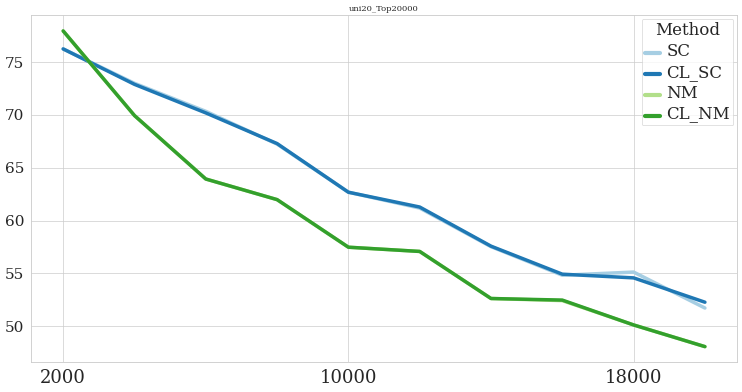

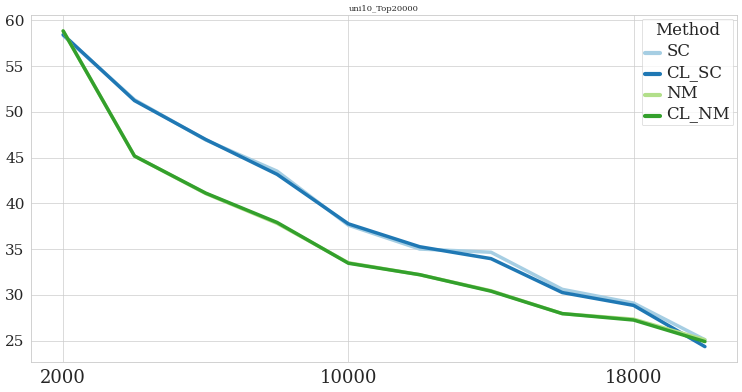

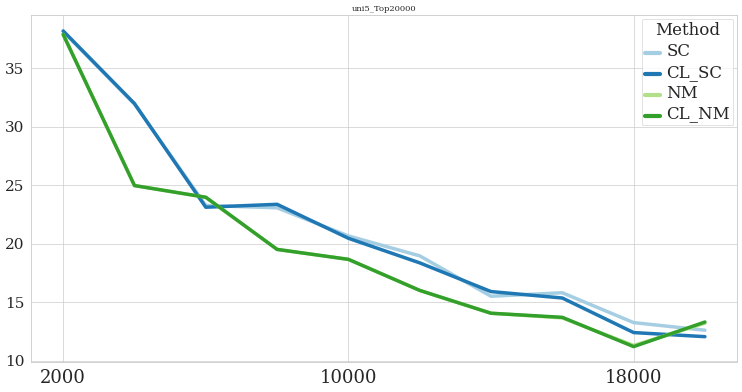

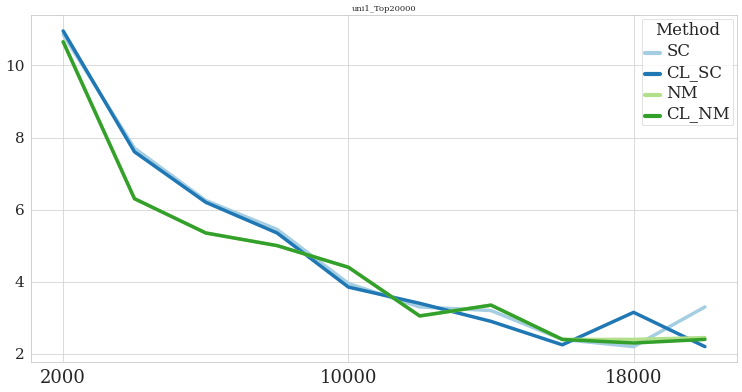

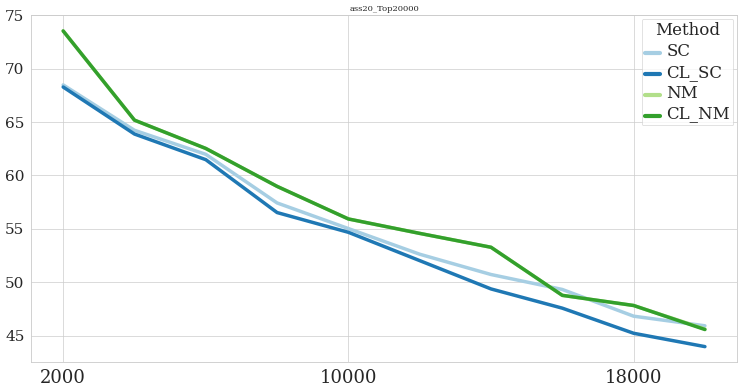

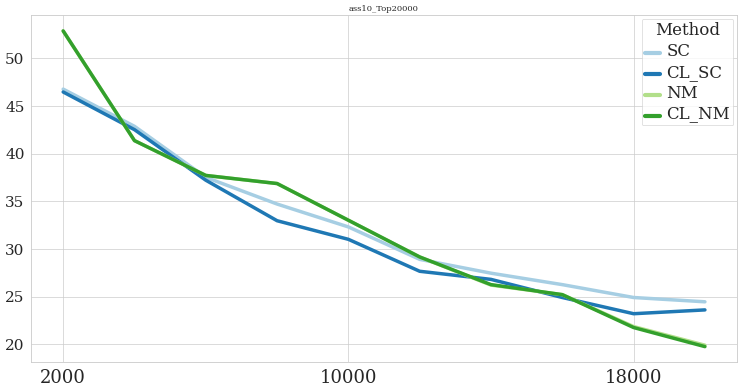

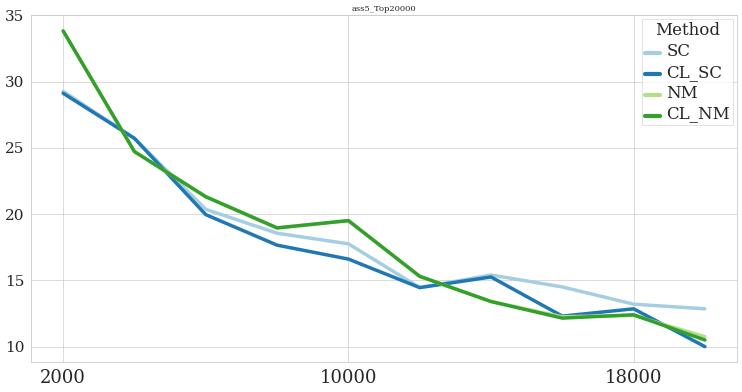

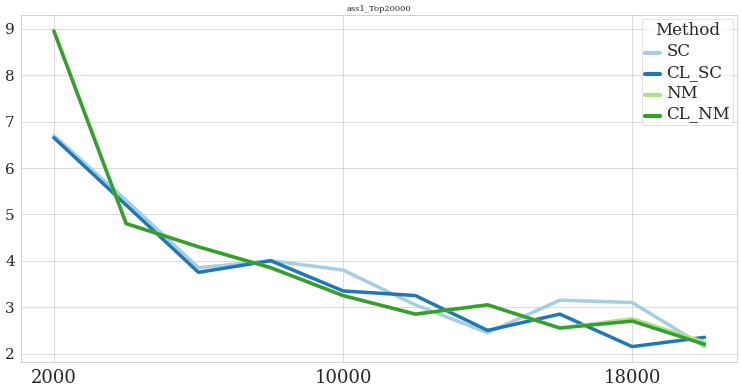

In [46]:
# import warnings
# warnings.filterwarnings('ignore')

# def convert_cumsum(tpfp_list, topn, interval):
#     num_tps = []
#     precisions = []
#     for i in range(0, topn, interval):
#         start = i
#         end = i + (interval-1)
#         if len(tpfp_list[start:end]) == 0:
#             num_tp = 0
#         else:
#             num_tp = sum(tpfp_list[start:end] == 'TP')

#             if len(tpfp_list[start:end]) == 0:
#                 precision = 0
#             else:
#                 precision = 100.0*sum(tpfp_list[start:end] == 'TP') / len(tpfp_list[start:end])

#         num_tps.append(num_tp)
#         precisions.append(precision)

#     cumsum = np.cumsum(num_tps)

#     return num_tps, cumsum, precisions


# def draw_precision_segment_cum_std(df, x, total_num, ftitle, tmp_figpath, topn, interval, y, hue, show_total):
#     # if len(df) == 0:
#     #     return
#     dpi = 50
#     fig = plt.figure(dpi=dpi, figsize=(15,8))
#     sns.set_theme(style="whitegrid", font="serif")
#     sns.set_palette("Paired")
#     # plt.style.use(['science','ieee'])
    
#     linewidth = 5

#     if hue == 'Epoch':
#         ax = sns.lineplot(x='Interval', y=y, data=df, hue=hue, linewidth=linewidth, legend='full')
#     else:
#         ax = sns.lineplot(x='Interval', y=y, data=df, hue=hue, linewidth=linewidth, err_style="bars", errorbar=("se", 2))

#     leg = ax.legend()
#     for i in leg.legendHandles:
#         i.set_linewidth(6)

#     leg.set_title(hue)
#     leg.get_title().set_fontsize('24')
#     plt.setp(ax.get_legend().get_texts(), fontsize=24)
#     ax.set(xlabel='', ylabel = '')
#     ax.tick_params(axis='x', labelsize=26)
#     ax.tick_params(axis='y', labelsize=22)

#     # if y == 'Precision':
#     #     ax.set_ylim(0, 100)

#     every_nth_xtick = 4
#     plt.xticks(np.arange(0, len(x)+1, every_nth_xtick))

#     if show_total is True:
#         ax.axhline(total_num, color='r')
#         yticks = [*ax.get_yticks(), total_num]
#         yticklabels = [*ax.get_yticklabels(), int(total_num)]
#         ax.set_yticks(yticks, labels=yticklabels)

#     plt.title(ftitle)

#     plt.tight_layout()
#     # plt.savefig(f'{tmp_figpath}/{ftitle}.png', dpi=dpi)
#     plt.show()

# #######################################
# #             one noise pattern, combined epoch with std
# #######################################
# # m_name = 'uni20'
# # m_names = ['uni1']
# m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
# # m_names = ['clean_uni1', 'uni1', 'clean_ass1', 'ass1']
# # m_names = ['clean', 'clean_uni20', 'uni20','clean_uni1', 'uni1', 'clean_ass20', 'ass20', 'clean_ass1', 'ass1']

# for m_name in m_names:

#     # methods = ['CL_SC', 'SC', 'CL_RC','RC', 'LRank', 'CL_NM', 'NM', 'CL_EN', 'EN', 'CL_REN','REN', 'CL_CWE']
#     # methods = ['SC', 'CL_SC', 'NM', 'CL_NM', 'REN', 'CL_REN', 'EN','CL_EN']
#     # methods = ['CL_NM'] # for comparing epoch
#     methods = ['SC', 'CL_SC', 'NM', 'CL_NM'] # standard
#     # methods = ['CL_SC', 'SC']
#     # methods = ['CL_RC', 'RC']
#     # methods = ['CL_EN', 'EN']
#     # methods = ['CL_REN', 'REN']
#     # methods = ['CL_NM', 'NM']

#     # tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_cumsum'
#     # tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_cumsum_per_epoch'
#     # tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_precision_per_epoch'
#     # tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_precision'
#     # tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_precision_flex'
#     # tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_cumsum_perclass'
#     # tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/4_Experiment/shift_fasterrcnn_precision_perclass'
#     tmp_figpath = ''


#     topn = 20000
#     interval = 2000
#     x = [f'{i+interval}' for i in range(0, topn, interval)]
#     colnames = ["Method", "Class", "Interval", "Cumsum", "Sum", "Precision"]
#     df_cum = pd.DataFrame(columns=colnames)

#     for method in methods:
#         tpfp_arr = topn_dic[m_name][method]['all'].values
#         num_tps, cumsum, precisions = convert_cumsum(tpfp_arr, topn, interval)
#         data = {
#             "Method": [method]*len(x),
#             "Class": ['all']*len(x),
#             "Interval": x,
#             "Cumsum": cumsum,
#             "Sum": num_tps,
#             "Precision": precisions
#         }
#         df_epo = pd.DataFrame(data=data, columns=colnames)
#         df_cum = pd.concat([df_cum, df_epo], axis=0, ignore_index=True)

#     ftitle = f'{m_name}_Top{topn}'
#     show_total = False
#     # y = 'Cumsum'
#     y = 'Precision'
#     hue = 'Method'
#     # hue = 'Epoch'
#     total_num = total_incorrects[m_name]['all']
#     draw_precision_segment_cum_std(df_cum, x, total_num, ftitle, tmp_figpath, topn, interval, y, hue, show_total)
#     print('')


#     # topn = 2000
#     # interval = 200
#     # x = [f'{i+interval}' for i in range(0, topn, interval)]
#     # colnames = ["Method", "Class", "Interval", "Cumsum", "Sum", "Precision"]
#     # df_cum = pd.DataFrame(columns=colnames)

#     # for method in methods:

#     #     tpfp_arr = topn_dic[m_name][method]['all'].values
#     #     num_tps, cumsum, precisions = convert_cumsum(tpfp_arr, topn, interval)
#     #     data = {
#     #         "Method": [method]*len(x),
#     #         "Class": ['all']*len(x),
#     #         "Interval": x,
#     #         "Cumsum": cumsum,
#     #         "Sum": num_tps,
#     #         "Precision": precisions
#     #     }
#     #     df_epo = pd.DataFrame(data=data, columns=colnames)
#     #     df_cum = pd.concat([df_cum, df_epo], axis=0, ignore_index=True)
#     # ftitle = f'{m_name}_Top{topn}'
#     # total_num = total_incorrects[m_name]['all']
#     # draw_precision_segment_cum_std(df_cum, x, total_num, ftitle, tmp_figpath, topn, interval, y, hue, show_total)
#     # print('')

# #############################
# #                  Per class figure
# #############################

# # topn = 5000
# # interval = 500
# # # epos = list(range(1, 9))
# # epos = [1]
# # x = [f'{i+interval}' for i in range(0, topn, interval)]
# # colnames = ["Model", "Epoch", "Method", "Class", "Interval", "Cumsum", "Sum", "Precision"]
# # df_cum = pd.DataFrame(columns=colnames)
# # # m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
# # m_names = ['ass1']
# # for m_name in m_names:
# #     for method in methods:
# #         for epo in epos:
# #             for classname in id2class.values():
# #                 tpfp_arr = topn_byclass_dic[m_name][epo][method][classname].values
# #                 num_tps, cumsum, precisions = convert_cumsum(tpfp_arr, topn, interval)
# #                 data = {
# #                     "Model": m_name,
# #                     "Epoch": epo,
# #                     "Method": [method]*len(x),
# #                     "Class": [classname]*len(x),
# #                     "Interval": x,
# #                     "Cumsum": cumsum,
# #                     "Sum": num_tps,
# #                     "Precision": precisions
# #                 }
# #                 df_epo = pd.DataFrame(data=data, columns=colnames)

# #                 # print(f'Processing {m_name} {classname} {method} epoch {epo}')
# #                 # if m_name == 'ass1' and epo == 1 and method == 'CL_SC' and classname == 'car':
# #                 #     print('Happened Once')

# #                 df_cum = pd.concat([df_cum, df_epo], axis=0, ignore_index=True)


# # show_total = False
# # y = 'Precision'
# # # y = 'Cumsum'
# # hue = 'Method'
# # for m_name in m_names:
# #     for classname in id2class.values():
# #         # classname = 'motorcycle'
# #         ftitle = f'{classname}_{m_name}'
# #         total_num = total_byclass_incorrects[m_name][classname]
# #         df_cum_byclass = df_cum.loc[(df_cum['Model']==m_name)&(df_cum['Class']==classname)&(df_cum['Epoch']==1), :]
# #         # df_cum_byclass = df_cum.loc[df_cum['Class']==classname, :]
# #         draw_precision_segment_cum_std(df_cum_byclass, x, total_num, ftitle, tmp_figpath, topn, interval, y, hue, show_total)


# AED Percentage/Cumsum stacked bar

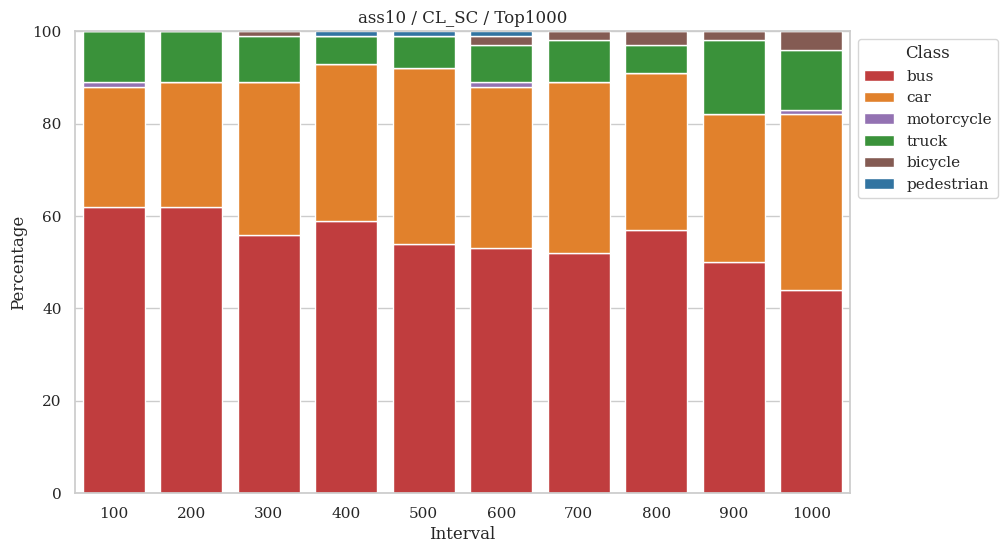

In [47]:

from collections import Counter


def draw_stacked_bar(df, ftitle, datatype):
    # Compute count of each class within each interval
    count_df = df.groupby(['Interval', 'labels_gt_des']).size().reset_index(name='count')
    
    # Check if we need percentage or cumulative sum
    if datatype == 'percent':
        # Compute the total for each interval
        total = count_df.groupby('Interval')['count'].transform('sum')
        # Compute the percentage
        count_df['value'] = 100 * (count_df['count'] / total)

    elif datatype == 'cumsum':
        # Compute the cumulative sum
        count_df['value'] = count_df.groupby('labels_gt_des')['count'].cumsum()

    # elif datatype == 'precision':
    #     # Compute the total for each interval
    #     total = count_df.groupby('Interval')['count'].transform('sum')
    #     # Compute the percentage
    #     count_df['value'] = 100 * (count_df['count'] / total)


    # Pivot the dataframe to make it suitable for stacked barplot
    pivoted_df = count_df.pivot(index='Interval', columns='labels_gt_des', values='value').reset_index()
    pivoted_df.fillna(0, inplace=True)  # Fill missing classes with 0

    # Define a color mapping for classes
    colors = sns.color_palette("tab10", len(id2class.items()))
    class_colors = {k: colors[i] for i, k in id2class.items()}

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Track bottom values for stacked bars
    bottoms = {interval: 0 for interval in pivoted_df['Interval']}

    # Dynamically stack bars based on unique labels and use predefined colors
    for label in count_df['labels_gt_des'].unique():
        sns.barplot(x='Interval', y=label, data=pivoted_df, label=label, 
                    bottom=[bottoms[interval] for interval in pivoted_df['Interval']], color=class_colors[label])
        
        # Update the bottom values for the next class
        for interval in pivoted_df['Interval']:
            bottoms[interval] += pivoted_df.loc[pivoted_df['Interval'] == interval, label].values[0]

    ylabel = 'Percentage' if datatype else 'Cumulative Sum'
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Interval')
    ax.legend(title="Class", loc="upper left", bbox_to_anchor=(1, 1))
    ax.set_title(ftitle)

    plt.show()

####################################
# m_names = ['clean', 'clean_uni20', 'uni20','clean_uni1', 'uni1', 'clean_ass20', 'ass20', 'clean_ass1', 'ass1']
# m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
m_names = ['ass10']
# m_names = ['clean', 'clean_uni1', 'uni1', 'clean_ass1', 'ass1']
# m_names = ['clean', 'clean_uni1', 'uni1', 'clean_ass1', 'ass1']
# m_names = ['clean_ass1', 'ass1']
methods = ['SC']
# epos = [1]
# epos = list(range(1, 9))

topn = 1000
num_intervals = 10
# x = [f'{i+interval}' for i in range(0, topn, interval)]
# colnames = ["Model", "Method", "Epoch", "Class", "Interval", "Cumsum", "Sum", "Precision"]
# df_cum = pd.DataFrame(columns=colnames)

for m_name in m_names:
    for method in methods:
            dic = {
                'true_labels_des': topn_dic[m_name][method]['true_labels_des'][:topn],
                'labels_gt_des': topn_dic[m_name][method]['labels_gt_des'][:topn]
            }
            
            # Example data
            # topn = 1000  # Define your desired value for topn
            # dic = {
            #     'labels_gt_des': (['car']*3+['truck']*2+['bus']*5)*10,
            # }
            # Create dataframe
            df = pd.DataFrame(dic)

            # Cap the dataframe to the first topn rows
            # df = df.head(topn)

            # Create a dynamic 'Interval' column
            interval_size = topn // num_intervals
            df['Interval'] = np.repeat(np.arange(1, num_intervals+1) * interval_size, interval_size)

            ftitle = f'{m_name} / {method} / Top{topn}'
            # draw_stacked_bar(df, ftitle, datatype='cumsum')
            draw_stacked_bar(df, ftitle, datatype='percent')

print('')

# Look into details (stacked bar with precision)
# AED Performance: P@K, R@K 

In [33]:
# topn_dic = aed_topn['all']
# total_incorrects = aed_topn['all_incorrect']
# topn_byclass_dic = aed_topn['byclass']
# total_byclass_incorrects = aed_topn['byclass_incorrect']
# topn_byclass_dic['uni10']['CL_SC']['car'][-10:]
topn_dic['uni10']['CL_SC']['all'][-10:]

7216     TN
2245     TN
1704     TN
7596     TN
7641     TN
11442    TN
2265     TN
9289     TN
3507     TN
7907     TN
Name: c_incorrect, dtype: object

0it [00:00, ?it/s]

Process uni20 CL_SC 1
total_c_incorrect=2887, total_c_correct=11436
Confident confident_joint_thresh=2504 len(df) =14323
Final Confident confident_joint_thresh=2504 for CL_SC
Process uni20 CL_SC 2
total_c_incorrect=2933, total_c_correct=11390
Confident confident_joint_thresh=2606 len(df) =14323
Final Confident confident_joint_thresh=2606 for CL_SC
Process uni20 CL_SC 3
total_c_incorrect=2921, total_c_correct=11402
Confident confident_joint_thresh=2612 len(df) =14323
Final Confident confident_joint_thresh=2612 for CL_SC
Process uni20 CL_SC 4
total_c_incorrect=2848, total_c_correct=11475
Confident confident_joint_thresh=2568 len(df) =14323
Final Confident confident_joint_thresh=2568 for CL_SC
Process uni20 CL_SC 5
total_c_incorrect=2857, total_c_correct=11466
Confident confident_joint_thresh=2545 len(df) =14323
Final Confident confident_joint_thresh=2545 for CL_SC
Process uni20 SC 1
total_c_incorrect=2887, total_c_correct=11436
Confident confident_joint_thresh=None len(df) =14323
Final C

/tmp/ipykernel_544818/1003838244.py:451: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


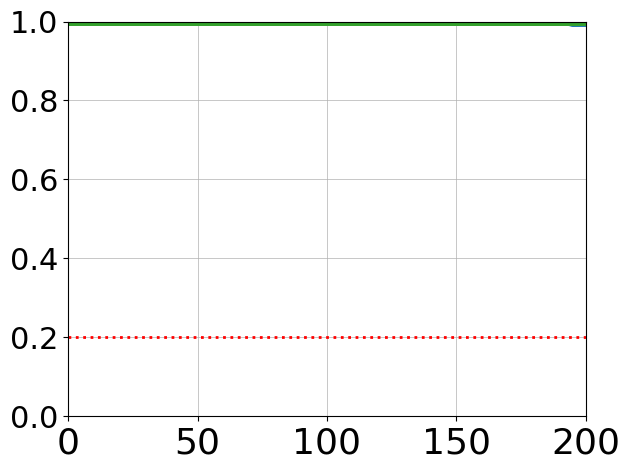

1it [00:03,  3.56s/it]

---------------- end of uni20 ----------------
Process ass20 CL_SC 1
total_c_incorrect=2920, total_c_correct=11403
Confident confident_joint_thresh=2283 len(df) =14323
Final Confident confident_joint_thresh=2283 for CL_SC
Process ass20 CL_SC 2
total_c_incorrect=2870, total_c_correct=11453
Confident confident_joint_thresh=2227 len(df) =14323
Final Confident confident_joint_thresh=2227 for CL_SC
Process ass20 CL_SC 3
total_c_incorrect=2889, total_c_correct=11434
Confident confident_joint_thresh=2313 len(df) =14323
Final Confident confident_joint_thresh=2313 for CL_SC
Process ass20 CL_SC 4
total_c_incorrect=2860, total_c_correct=11463
Confident confident_joint_thresh=2178 len(df) =14323
Final Confident confident_joint_thresh=2178 for CL_SC
Process ass20 CL_SC 5
total_c_incorrect=2861, total_c_correct=11462
Confident confident_joint_thresh=2269 len(df) =14323
Final Confident confident_joint_thresh=2269 for CL_SC
Process ass20 SC 1
total_c_incorrect=2920, total_c_correct=11403
Confident con

/tmp/ipykernel_544818/1003838244.py:451: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


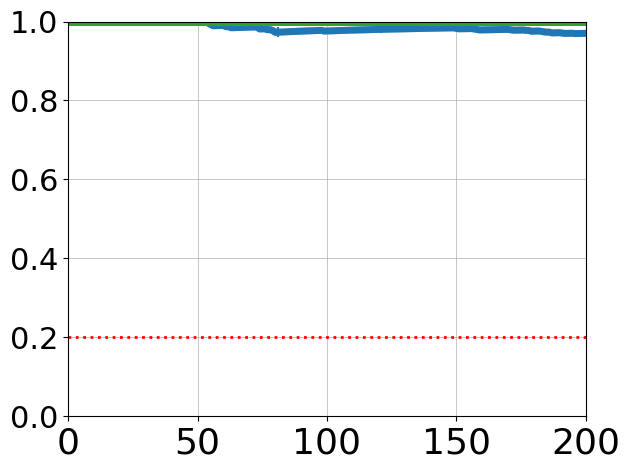

2it [00:06,  3.42s/it]

---------------- end of ass20 ----------------
Process uni10 CL_SC 1
total_c_incorrect=1446, total_c_correct=12877
Confident confident_joint_thresh=1365 len(df) =14323
Final Confident confident_joint_thresh=1365 for CL_SC
Process uni10 CL_SC 2
total_c_incorrect=1438, total_c_correct=12885
Confident confident_joint_thresh=1343 len(df) =14323
Final Confident confident_joint_thresh=1343 for CL_SC
Process uni10 CL_SC 3
total_c_incorrect=1402, total_c_correct=12921
Confident confident_joint_thresh=1311 len(df) =14323
Final Confident confident_joint_thresh=1311 for CL_SC
Process uni10 CL_SC 4
total_c_incorrect=1429, total_c_correct=12894
Confident confident_joint_thresh=1360 len(df) =14323
Final Confident confident_joint_thresh=1360 for CL_SC
Process uni10 CL_SC 5
total_c_incorrect=1352, total_c_correct=12971
Confident confident_joint_thresh=1248 len(df) =14323
Final Confident confident_joint_thresh=1248 for CL_SC
Process uni10 SC 1
total_c_incorrect=1446, total_c_correct=12877
Confident con

/tmp/ipykernel_544818/1003838244.py:451: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


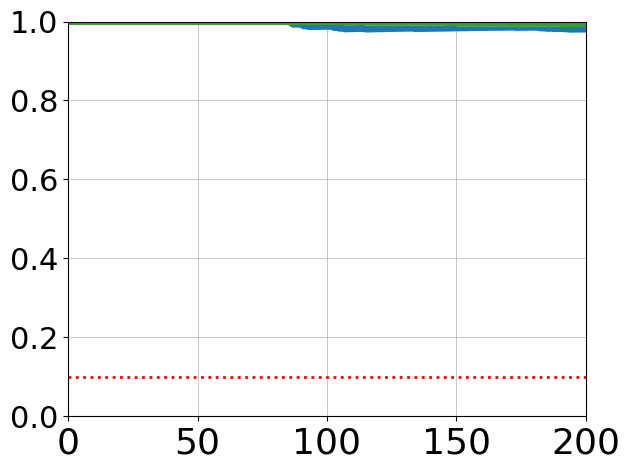

3it [00:10,  3.40s/it]

---------------- end of uni10 ----------------
Process ass10 CL_SC 1
total_c_incorrect=1392, total_c_correct=12931
Confident confident_joint_thresh=1168 len(df) =14323
Final Confident confident_joint_thresh=1168 for CL_SC
Process ass10 CL_SC 2
total_c_incorrect=1424, total_c_correct=12899
Confident confident_joint_thresh=1144 len(df) =14323
Final Confident confident_joint_thresh=1144 for CL_SC
Process ass10 CL_SC 3
total_c_incorrect=1416, total_c_correct=12907
Confident confident_joint_thresh=1150 len(df) =14323
Final Confident confident_joint_thresh=1150 for CL_SC
Process ass10 CL_SC 4
total_c_incorrect=1485, total_c_correct=12838
Confident confident_joint_thresh=1252 len(df) =14323
Final Confident confident_joint_thresh=1252 for CL_SC
Process ass10 CL_SC 5
total_c_incorrect=1478, total_c_correct=12845
Confident confident_joint_thresh=1203 len(df) =14323
Final Confident confident_joint_thresh=1203 for CL_SC
Process ass10 SC 1
total_c_incorrect=1392, total_c_correct=12931
Confident con

/tmp/ipykernel_544818/1003838244.py:451: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


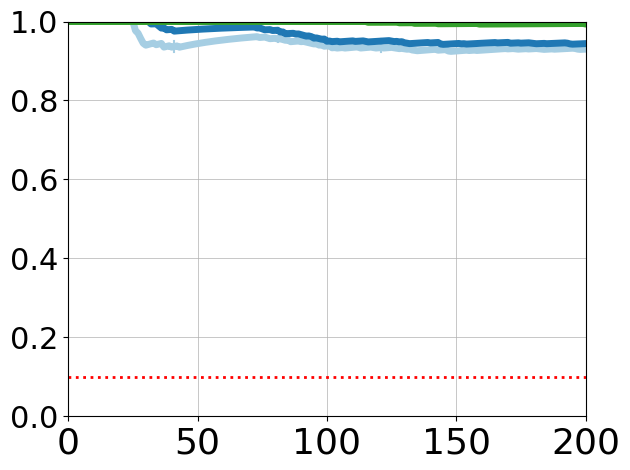

4it [00:13,  3.44s/it]

---------------- end of ass10 ----------------
Process uni5 CL_SC 1
total_c_incorrect=726, total_c_correct=13597
Confident confident_joint_thresh=684 len(df) =14323
Final Confident confident_joint_thresh=684 for CL_SC
Process uni5 CL_SC 2
total_c_incorrect=758, total_c_correct=13565
Confident confident_joint_thresh=727 len(df) =14323
Final Confident confident_joint_thresh=727 for CL_SC
Process uni5 CL_SC 3
total_c_incorrect=676, total_c_correct=13647
Confident confident_joint_thresh=636 len(df) =14323
Final Confident confident_joint_thresh=636 for CL_SC
Process uni5 CL_SC 4
total_c_incorrect=703, total_c_correct=13620
Confident confident_joint_thresh=669 len(df) =14323
Final Confident confident_joint_thresh=669 for CL_SC
Process uni5 CL_SC 5
total_c_incorrect=759, total_c_correct=13564
Confident confident_joint_thresh=745 len(df) =14323
Final Confident confident_joint_thresh=745 for CL_SC
Process uni5 SC 1
total_c_incorrect=726, total_c_correct=13597
Confident confident_joint_thresh=No

/tmp/ipykernel_544818/1003838244.py:451: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


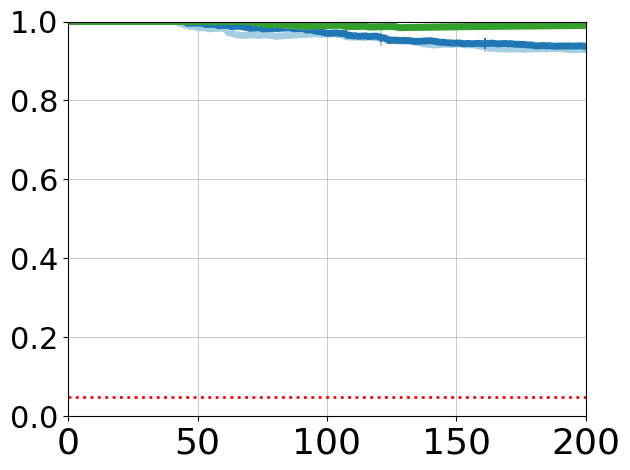

5it [00:17,  3.52s/it]

---------------- end of uni5 ----------------
Process ass5 CL_SC 1
total_c_incorrect=729, total_c_correct=13594
Confident confident_joint_thresh=629 len(df) =14323
Final Confident confident_joint_thresh=629 for CL_SC
Process ass5 CL_SC 2
total_c_incorrect=727, total_c_correct=13596
Confident confident_joint_thresh=630 len(df) =14323
Final Confident confident_joint_thresh=630 for CL_SC
Process ass5 CL_SC 3
total_c_incorrect=719, total_c_correct=13604
Confident confident_joint_thresh=637 len(df) =14323
Final Confident confident_joint_thresh=637 for CL_SC
Process ass5 CL_SC 4
total_c_incorrect=726, total_c_correct=13597
Confident confident_joint_thresh=653 len(df) =14323
Final Confident confident_joint_thresh=653 for CL_SC
Process ass5 CL_SC 5
total_c_incorrect=710, total_c_correct=13613
Confident confident_joint_thresh=660 len(df) =14323
Final Confident confident_joint_thresh=660 for CL_SC
Process ass5 SC 1
total_c_incorrect=729, total_c_correct=13594
Confident confident_joint_thresh=Non

/tmp/ipykernel_544818/1003838244.py:451: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


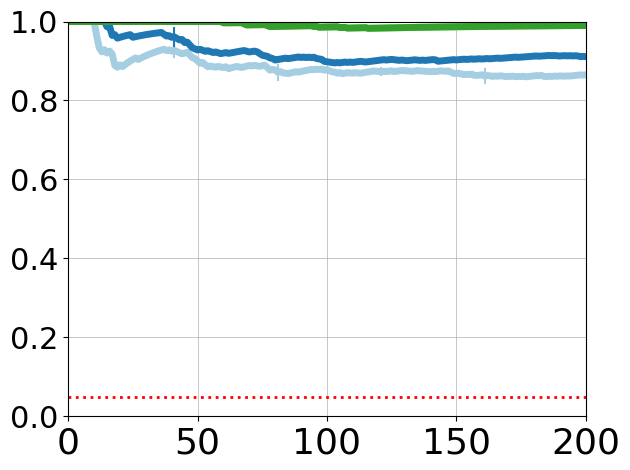

6it [00:20,  3.43s/it]

---------------- end of ass5 ----------------
Process uni1 CL_SC 1
total_c_incorrect=145, total_c_correct=14178
Confident confident_joint_thresh=211 len(df) =14323
Final Confident confident_joint_thresh=211 for CL_SC
Process uni1 CL_SC 2
total_c_incorrect=144, total_c_correct=14179
Confident confident_joint_thresh=195 len(df) =14323
Final Confident confident_joint_thresh=195 for CL_SC
Process uni1 CL_SC 3
total_c_incorrect=165, total_c_correct=14158
Confident confident_joint_thresh=215 len(df) =14323
Final Confident confident_joint_thresh=215 for CL_SC
Process uni1 CL_SC 4
total_c_incorrect=159, total_c_correct=14164
Confident confident_joint_thresh=212 len(df) =14323
Final Confident confident_joint_thresh=212 for CL_SC
Process uni1 CL_SC 5
total_c_incorrect=149, total_c_correct=14174
Confident confident_joint_thresh=200 len(df) =14323
Final Confident confident_joint_thresh=200 for CL_SC
Process uni1 SC 1
total_c_incorrect=145, total_c_correct=14178
Confident confident_joint_thresh=Non

/tmp/ipykernel_544818/1003838244.py:451: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


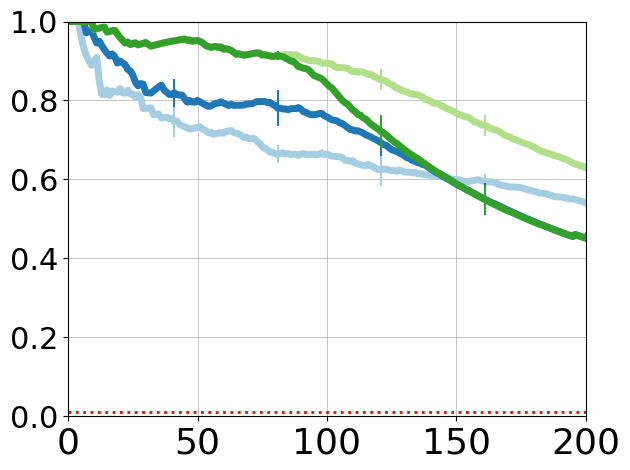

7it [00:24,  3.60s/it]

---------------- end of uni1 ----------------
Process ass1 CL_SC 1
total_c_incorrect=132, total_c_correct=14191
Confident confident_joint_thresh=189 len(df) =14323
Final Confident confident_joint_thresh=189 for CL_SC
Process ass1 CL_SC 2
total_c_incorrect=150, total_c_correct=14173
Confident confident_joint_thresh=190 len(df) =14323
Final Confident confident_joint_thresh=190 for CL_SC
Process ass1 CL_SC 3
total_c_incorrect=144, total_c_correct=14179
Confident confident_joint_thresh=204 len(df) =14323
Final Confident confident_joint_thresh=204 for CL_SC
Process ass1 CL_SC 4
total_c_incorrect=147, total_c_correct=14176
Confident confident_joint_thresh=188 len(df) =14323
Final Confident confident_joint_thresh=188 for CL_SC
Process ass1 CL_SC 5
total_c_incorrect=155, total_c_correct=14168
Confident confident_joint_thresh=215 len(df) =14323
Final Confident confident_joint_thresh=215 for CL_SC
Process ass1 SC 1
total_c_incorrect=132, total_c_correct=14191
Confident confident_joint_thresh=Non

/tmp/ipykernel_544818/1003838244.py:451: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


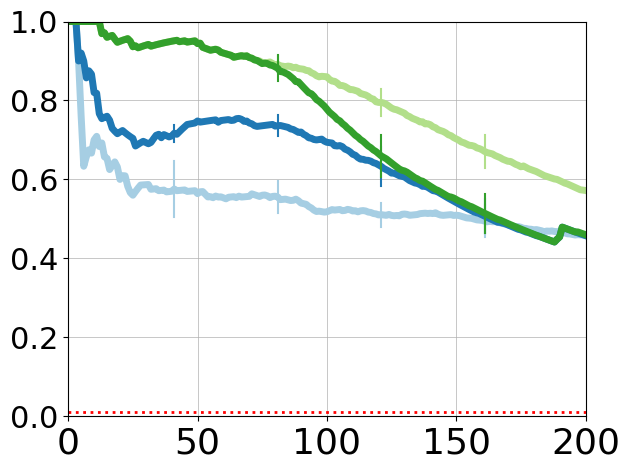

8it [00:29,  3.64s/it]

---------------- end of ass1 ----------------
duration=00:00:29



In [60]:
from matplotlib.ticker import FuncFormatter
from statistics import mean



def get_sorted_idxes_and_c_incorrect(df, classname, colname, is_remove):

    li = []

    if classname == 'all':
        class_df = df.copy()
    else:
        class_df = df.loc[df['label_gt_des']==classname]
    
    if colname[:3] == 'CL_':
        if is_remove is True:
            class_df = df.loc[df[colname] != 999999]
        class_df = class_df.sort_values(by=colname, ascending=True)

        # li is always cut by 999999
        li = df.loc[df[colname] != 999999].index.values

    elif colname in ['NM', 'SC', 'EN']:
        class_df = class_df.sort_values(by=colname, ascending=True, inplace=False)
        li = class_df.index.values
        
    elif colname in ['REN', 'RC']:
        class_df = class_df.sort_values(by=colname, ascending=False, inplace=False)
        li = class_df.index.values

    value_count = class_df['c_incorrect'].value_counts()

    # if True not in value_count.index:


    total_c_incorrect = class_df['c_incorrect'].value_counts()[True]
    total_c_correct = class_df['c_incorrect'].value_counts()[False]

    return li, class_df, total_c_incorrect, total_c_correct


def process_interval_counts_per_class(df, figdir, img_prefix, classname):

    if 'precision_true_perclass' in figdir:
        legend_label_des = 'true_label_des'
    else:
        legend_label_des = 'label_pred_des'

    grouped_df = df.groupby(['Interval', 'label_gt_des', legend_label_des]).size().reset_index(name='count')

    # grouped_df = df.groupby(['Interval', 'label_gt_des', legend_label_des]).size()
    # grouped_df = grouped_df.unstack(fill_value=0).stack().reset_index(name='count')

    # Compute precision
    total_for_label = grouped_df.groupby(['Interval', 'label_gt_des'])['count'].sum(min_count=1).reset_index(name='total_for_label')

    if legend_label_des == 'true_label_des':
        correct_preds = grouped_df[grouped_df['label_gt_des'] != grouped_df[legend_label_des]]
    elif legend_label_des == 'label_pred_des':
        correct_preds = grouped_df[grouped_df['label_gt_des'] == grouped_df[legend_label_des]]

    true_positive = correct_preds.groupby(['Interval', 'label_gt_des'])['count'].sum(min_count=1).reset_index(name='true_positive')
    precision_df = pd.merge(total_for_label, true_positive, on=['Interval', 'label_gt_des'], how='left').fillna(0)
    precision_df['precision'] = precision_df['true_positive'] / precision_df['total_for_label']

    pivoted_df = grouped_df.pivot_table(index=['Interval', 'label_gt_des'], columns=legend_label_des, values='count', fill_value=0, aggfunc=lambda x: x.sum(min_count=1)).unstack().fillna(0).stack().reset_index()

    # pivoted_df = grouped_df.pivot_table(index=['Interval', 'label_gt_des'], columns=legend_label_des, values='count', fill_value=0, aggfunc='count').unstack().rename(columns={0:'count'}).reset_index()

    unique_labels = id2class.values()
    true_labels = id2class.values()

    colors = sns.color_palette("tab10", len(id2class.items()))
    class_colors = {i: colors[i] for i, k in id2class.items()}

    for label in unique_labels:

        if classname != 'all' and label != classname:
            continue

        data = pivoted_df[pivoted_df['label_gt_des'] == label].copy()
        precision_data = precision_df[precision_df['label_gt_des'] == label]

        # Ensure data contains columns for all true_labels
        for true_label in true_labels:
            if true_label not in data:
                data[true_label] = 0
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plotting the bars with increased width
        print(f'len of df = {len(df)}')
        if len(df) >= 110000:
            bar_width = 2000
        elif len(df) >= 10000:
            bar_width = 200
        elif len(df) >= 4000:
            bar_width = 100
        elif len(df) >= 1000:
            bar_width = 70
        else:
            bar_width = 20

        bottom_data = [0] * len(data)

        for idx, true_label in enumerate(true_labels):
            ax.bar(data['Interval'], data[true_label], bottom=bottom_data, label=true_label, color=class_colors[idx], width=bar_width)
            # ax.bar(data['Interval'], data[true_label], bottom=bottom_data, label=true_label, color=colors[idx], width=bar_width)
            bottom_data = [i+j for i,j in zip(bottom_data, data[true_label].tolist())]




        
        # Twin the y-axis for the line plot
        ax2 = ax.twinx()
        ax2.set_ylim(0, 1)
        sns.lineplot(x='Interval', y='precision', data=precision_data, ax=ax2, color='black', marker='o', label='Precision')
        ax2.set_ylabel('Precision')

        # Combining legends from both axes
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        plt.setp(ax2.get_legend().get_texts(), fontsize=16)
        ax.set(xlabel='', ylabel = '')
        ax2.set(xlabel='', ylabel = '')
        ax.tick_params(axis='x', labelsize=26)
        ax.tick_params(axis='y', labelsize=22)
        ax2.tick_params(axis='y', labelsize=22)

        # ax2.get_legend().set_visible(False)

        if max(bottom_data) <= 10:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
        elif max(bottom_data) <= 20:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=2))
        elif max(bottom_data) <= 50:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=5))
        elif max(bottom_data) <= 100:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10))
        elif max(bottom_data) <= 200:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=20))
        elif max(bottom_data) <= 300:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=30))
        elif max(bottom_data) >= 1000:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=50))
        elif max(bottom_data) >= 10000:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=500))
        else:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=40))


        # Do not use it for thesis
        # ax.set_ylabel('Count')
        # ax.set_xlabel('Interval')
        # ax.set_title(f"Class: {label}")
        
        plt.tight_layout()
        # plt.savefig(f'{figdir}/{img_prefix}_{label}.png', dpi=50)
        # plt.show()






def process_interval_precision(df, tmp_figpath, grouped_filepath, yaxis, topn, cut_by_confident_joint, total_c_incorrect, show_total):
    
    if yaxis == 'Precision':
        ############## Segmented Precision ##############
        # Group by 'Interval' and 'label_gt_des' and compute the sum of 'correct' and count of 'label_gt_des'
        grouped_df = df.groupby(['Interval', 'label_gt_des']).agg(total=('label_gt_des', 'size'), incorrect_sum=('c_incorrect', 'sum')).reset_index()

        # Calculate precision
        grouped_df['precision'] = grouped_df['incorrect_sum'] / grouped_df['total']

        ############## Precision at K ##############
    elif yaxis in ['patk', 'ratk', 'patk_all',  'ratk_all']:

        df['is_TP'] = (df['aed_tpfp'] == 'TP').astype(int)
        df['is_FP'] = (df['aed_tpfp'] == 'FP').astype(int)  
        df['is_TN'] = (df['aed_tpfp'] == 'TN').astype(int)  
        df['is_FN'] = (df['aed_tpfp'] == 'FN').astype(int)  

        if yaxis == 'patk':
            # Compute cumulative sum of TP and FP based on sorted intervals
            df = df.sort_values(by=['label_gt_des', 'Interval'])
            df['tp_cumsum'] = df.groupby(['label_gt_des'])['is_TP'].cumsum()
            df['fp_cumsum'] = df.groupby(['label_gt_des'])['is_FP'].cumsum()

            # Get the aggregated TP and FP at each unique interval
            grouped_df = df[df['Interval'].isin(df['Interval'].unique())].copy()
            grouped_df['total'] = grouped_df.groupby(['label_gt_des'])['Interval'].cumcount() + 1
            grouped_df['tp_sum'] = grouped_df['tp_cumsum']
            grouped_df['fp_sum'] = grouped_df['fp_cumsum']

            grouped_df['patk'] = grouped_df['tp_sum'] / (grouped_df['tp_sum'] + grouped_df['fp_sum'])
            grouped_df = grouped_df[['label_gt_des', 'Interval', 'total', 'tp_sum', 'fp_sum', 'patk']].reset_index(drop=True)

        elif yaxis == 'ratk':

            # Compute cumulative sum of TP based on sorted intervals
            df = df.sort_values(by=['label_gt_des', 'Interval', 'Epoch'])
            df['tp_cumsum'] = df.groupby(['label_gt_des', 'Epoch'])['is_TP'].cumsum()

            # Get the aggregated TP at each unique interval
            grouped_df = df[df['Interval'].isin(df['Interval'].unique())].copy()
            grouped_df['tp_sum'] = grouped_df['tp_cumsum']

            # Total relevant items for a class = TP + FN
            total_relevant = df.groupby(['label_gt_des', 'Epoch']).agg(total_relevant=('aed_tpfp', lambda x: (x == 'TP').sum() + (x == 'FN').sum())).reset_index()

            # Merge the relevant count to our grouped_df
            grouped_df = pd.merge(grouped_df, total_relevant, on=['label_gt_des', 'Epoch'], how='left')

            # Calculate recall at k
            grouped_df['ratk'] = grouped_df['tp_sum'] / grouped_df['total_relevant']
            grouped_df = grouped_df[['label_gt_des', 'Epoch', 'Interval', 'tp_sum', 'total_relevant', 'ratk']].reset_index(drop=True)
        
        elif yaxis == 'patk_all':
            # Compute cumulative sum of TP and FP based on sorted intervals
            df = df.sort_values(by=['Method', 'Interval', 'Epoch'])
            df['tp_cumsum'] = df.groupby(['Method', 'Epoch'])['is_TP'].cumsum()
            df['fp_cumsum'] = df.groupby(['Method', 'Epoch'])['is_FP'].cumsum()

            # Get the aggregated TP and FP at each unique interval
            grouped_df = df[df['Interval'].isin(df['Interval'].unique())].copy()
            grouped_df['total'] = grouped_df.groupby(['Method', 'Epoch'])['Interval'].cumcount() + 1
            grouped_df['tp_sum'] = grouped_df['tp_cumsum']
            grouped_df['fp_sum'] = grouped_df['fp_cumsum']

            grouped_df[yaxis] = grouped_df['tp_sum'] / (grouped_df['tp_sum'] + grouped_df['fp_sum'])
            grouped_df = grouped_df[['Method', 'Epoch', 'Interval', 'total', 'tp_sum', 'fp_sum', 'confident_joint_thresh', yaxis]].reset_index(drop=True)

        elif yaxis ==  'ratk_all':
            # Compute cumulative sum of TP based on sorted intervals
            df = df.sort_values(by=['Method', 'Interval', 'Epoch'])
            df['tp_cumsum'] = df.groupby(['Method', 'Epoch'])['is_TP'].cumsum()

            # Get the aggregated TP at each unique interval
            grouped_df = df[df['Interval'].isin(df['Interval'].unique())].copy()
            grouped_df['tp_sum'] = grouped_df['tp_cumsum']

            # Total relevant items for a class = TP + FN
            total_relevant = df.groupby(['Method','Epoch']).agg(total_relevant=('aed_tpfp', lambda x: (x == 'TP').sum() + (x == 'FN').sum())).reset_index()

            # No longer stands forrandom rounds
            # assert total_relevant['total_relevant'].unique() == total_c_incorrect

            # Merge the relevant count to our grouped_df
            grouped_df = pd.merge(grouped_df, total_relevant, on=['Method', 'Epoch'], how='left')

            # Calculate recall at k
            grouped_df[yaxis] = grouped_df['tp_sum'] / grouped_df['total_relevant']
            grouped_df = grouped_df[['Method', 'Epoch', 'Interval', 'tp_sum', 'total_relevant', 'confident_joint_thresh', yaxis]].reset_index(drop=True)

    # if grouped_df_path is not None:
    #     grouped_df =pd.read_csv(grouped_df_path, index=False)
    # else:   
    #     grouped_df.to_csv(f'{grouped_filepath}', index=False)


    ##########################################
    # Hard-coded the colors for each class --> align with the shift classes
    # dict_values(['pedestrian', 'car', 'truck', 'bus', 'motorcycle', 'bicycle'])

    shiftall_class_order = ['person', 'car', 'truck', 'bus', 'motorcycle', 'bicycle']
    
    if yaxis in ['Precision', 'patk', 'ratk']:
        colors = sns.color_palette("tab10", len(id2class.items()))
        class_colors = {k: colors[i] for i, k in enumerate(shiftall_class_order)}
        hue_order =shiftall_class_order
    elif yaxis in [ 'patk_all', 'ratk_all']:
        # methods = df['method'].unique()
        methods = ['SC', 'CL_SC', 'NM', 'CL_NM']
        print(f'methods={methods}')
        sns.set_palette("Paired")
        colors = sns.color_palette("Paired", len(methods))
        class_colors = {k: colors[i] for i, k in enumerate(methods)}
        # print(f'class_colors={class_colors}')
        hue_order = methods

    grouped_df = grouped_df.loc[grouped_df['Interval'] <= topn+1]

    #######################################
    #              Cut the dataframe by confident joint                 #
    #######################################
    if cut_by_confident_joint is True:
        #  cut all methods by the same confident joint
        grouped_df = grouped_df.loc[grouped_df['Interval'] <= grouped_df['confident_joint_thresh']]

        topn = round(grouped_df['confident_joint_thresh'].mean())
        print(f'Cut by confident joint, average topn={topn}')
    else:
        #  cut only CL_ methods by the confident joint
        # conds = (grouped_df['Method']=='CL_SC') | (grouped_df['Method']=='CL_NM')
        cut_CL_SC_conds = (grouped_df['Method']=='CL_SC') & (grouped_df['Interval'] <= grouped_df['confident_joint_thresh'])
        cut_CL_NM_conds = (grouped_df['Method']=='CL_NM') & (grouped_df['Interval'] <= grouped_df['confident_joint_thresh'])
        other_conds = (grouped_df['Method']=='SC') | (grouped_df['Method']=='NM')

        cut_CL_SC = grouped_df.loc[cut_CL_SC_conds] 
        cut_CL_NM = grouped_df.loc[cut_CL_NM_conds] 
        other_df = grouped_df.loc[other_conds] 

        grouped_df = pd.concat([cut_CL_SC, cut_CL_NM, other_df])

        topn = topn

    ###########################################
    #                          Tranform Interval to percentage
    ###########################################
    grouped_df['Interval_percent'] = grouped_df['Interval'] / (1.0*topn)
    xaxis= 'Interval'
    # xaxis= 'Interval_percent'

    # Plotting
    if yaxis == 'Precision':
        plt.figure(figsize=(10, 6))
        ax = sns.lineplot(data=grouped_df, x="Interval", y="precision", hue="label_gt_des", hue_order=hue_order, marker="o", linestyle='dotted', palette=class_colors, markersize=20, linewidth=5) 
        # ax.set_ylim(-0.05,1)
    elif yaxis in ['patk', 'ratk']:
        # dot style
        # ax = sns.lineplot(data=grouped_df, x="Interval", y=yaxis, hue="label_gt_des", hue_order=hue_order, marker="o", linestyle='dotted', palette=class_colors, markersize=5, linewidth=1) 
        # solid line
        ax = sns.lineplot(data=grouped_df, x="Interval", y=yaxis, hue="label_gt_des", hue_order=hue_order, palette=class_colors, markersize=5, linewidth=2) 
        ax.set_ylim(0, 1)
        ax.set_xlim(xmin=0, xmax=topn)
        ################### Area under Curve ###################
        # Compute AUC for each class
        auc_results = {}
        unique_classes = grouped_df['label_gt_des'].unique()

        for label in unique_classes:
            class_df = grouped_df[grouped_df['label_gt_des'] == label].sort_values(by='Interval')
            auc = np.trapz(class_df[yaxis], class_df['Interval'])
            # Normalize AUC by dividing it with the maximum possible AUC
            auc_results[label] = auc / (1.0*topn)

        print('AUC Results')
        pp.pprint(auc_results)
        ###################################################
    elif yaxis in ['patk_all' ,'ratk_all']:
        ax = sns.lineplot(data=grouped_df, x=xaxis, y=yaxis,  hue="Method", markersize=1, linewidth=5,hue_order=hue_order, palette=class_colors, errorbar='sd', err_style='bars',err_kws={'errorevery': int(topn/5)})
        ax.set_ylim(0,1)
        # ax.set_ylim(auto=True)

        if xaxis == 'Interval_percent':
            ax.set_xlim(xmin=0, xmax=1)
        elif xaxis == 'Interval':
            ax.set_xlim(xmin=0, xmax=topn)
        # ax.axis('off')

        # ax.set_ylim(ymin=-0.005, ymax=1.005)
        # labels = ax.get_yticklabels()
        # # remove the first and the last labels
        # labels[0] = labels[-1] = ""
        # ax.set_yticklabels(labels)

        ################### Area under Curve ###################
        # Compute AUC for each class
        unique_methods = grouped_df['Method'].unique()
        auc_results = {k: {} for k in unique_methods}

        if m_name == 'ass1':
            print('')

        for method in unique_methods:
            epo_aucs = []
            epo_cf_threshs = []
            if m_name == 'uni1':
                print('')
            for epo in epos:
                epo_df = grouped_df.loc[(grouped_df['Method']==method)&(grouped_df['Epoch']==epo)].sort_values(by='Interval')
                auc = np.trapz(epo_df[yaxis], epo_df['Interval'])

                confident_joint_thresh = epo_df['confident_joint_thresh'].unique()

                assert confident_joint_thresh.shape[0] == 1

                confident_joint_thresh = confident_joint_thresh[0]

                if cut_by_confident_joint is True:
                    epo_cf_threshs.append(confident_joint_thresh)
                    auc = auc/(1.0*confident_joint_thresh)
                    epo_aucs.append(auc)

                else:
                    # topn should adopted to those confident joint < topn
                    if confident_joint_thresh < topn and method[:3] == 'CL_':
                        auc = auc/(1.0*confident_joint_thresh)
                    else:
                        auc = auc/(1.0*topn)
                    epo_aucs.append(auc)

            # Normalize AUC by dividing it with the maximum possible AUC
            if cut_by_confident_joint is True:
                auc_dic = {'avg': np.average(epo_aucs),
                                    'std': np.std(epo_aucs, ddof=1),
                                    'aucs': epo_aucs,
                                    'thresh_avg': np.average(epo_cf_threshs),
                                    'thresh_std': np.std(epo_cf_threshs, ddof=1),
                                    'thresh_aucs': epo_cf_threshs,
                                    }
            else:
                auc_dic = {'avg': np.average(epo_aucs),
                                    'std': np.std(epo_aucs, ddof=1),
                                    'aucs': epo_aucs
                                    }
            auc_results[method].update(auc_dic)

        print('AUC Results')
        pp.pprint(auc_results)
        print('')
        ###################################################
    
    if show_total is True and yaxis in ['patk_all']:
        noise_rate = tmp_figpath.split('_')[-1].replace('ass', '').replace('uni', '').replace('.png', '')
        noise_rate = int(noise_rate)*0.01
        ax.axhline(noise_rate, color='r', linestyle='dotted', linewidth=2)
        yticks = [*ax.get_yticks()]
        yticklabels = [*ax.get_yticklabels()]
        ax.set_yticks(yticks, labels=yticklabels)

    elif show_total is True and yaxis == 'ratk_all': 
        intervals = grouped_df[xaxis].unique()
        max_items = max([int(i) for i in intervals])
        min_items = min([int(i) for i in intervals])

        noise_rate = tmp_figpath.split('_')[-1].replace('ass', '').replace('uni', '').replace('.png', '')
        noise_rate = int(noise_rate)*0.01
        slope=noise_rate
        start_y = 0
        max_epo = max(df['Epoch'].unique())
        num_data_per_method = len(df)/(len(df['Method'].unique())*max_epo)
        end_y = (max_items*noise_rate)/ (num_data_per_method/topn*noise_rate)
        print(f'start_y={start_y}, slope={slope}')

        # this is for xaxis range from 0 to 1
        xy1 = (0,start_y)
        xy2 = (1,end_y)
        print(f'xy1 and xy2={xy1, xy2}')
        ax.axline(xy1, xy2, color='r', linestyle='dotted', linewidth=2)

        yticks = [*ax.get_yticks()]
        yticklabels = [*ax.get_yticklabels()]
        ax.set_yticks(yticks, labels=yticklabels)

    leg = ax.legend()
    for i in leg.legendHandles:
        i.set_linewidth(6)

    hue = 'Classes'

    # Not working
    # leg.set_title(hue)
    # leg.get_title().set_fontsize('40')

    plt.setp(ax.get_legend().get_texts(), fontsize=24)
    ax.set(xlabel='', ylabel = '')
    ax.tick_params(axis='x', labelsize=26)
    ax.tick_params(axis='y', labelsize=22)

    # Do not use it for thesis
    # plt.title("Precision of Classes Across Intervals")
    # plt.ylabel("Precision")
    # plt.xlabel("Interval")
    # plt.legend(title="Class")
    ax.get_legend().set_visible(False)
    
    plt.grid(linewidth = 0.5)
    plt.tight_layout()
    plt.savefig(f'{tmp_figpath}', dpi=80)
    plt.show()

    return auc_results

############################################
##################  Per Class  ##################
start = time.time()
# m_names = ['clean', 'clean_uni20', 'uni20','clean_uni1', 'uni1', 'clean_ass20', 'ass20', 'clean_ass1', 'ass1']
# m_names = [ 'uni20',  'ass20',  'uni10',  'ass10']
m_names = [ 'uni20',  'ass20',  'uni10',  'ass10', 'uni5',  'ass5', 'uni1',  'ass1']
# m_names = ['ass20']
# m_names = ['clean', 'clean_uni1', 'uni1', 'clean_ass1', 'ass1']
# m_names = ['uni1','ass20','ass1']
methods = ['CL_SC',  'SC','CL_NM', 'NM']
# methods = ['CL_SC', 'CL_NM']
# methods = ['CL_SC', 'SC']
# methods = ['CL_NM']

topn = None

epos = list(range(1, 6))


topn = 200
# show_total = False
show_total = True
# num_intervals = 10
cut_by_confident_joint = False
# cut_by_confident_joint = True

# Default to all
classname = 'all'
# yaxis = 'Precision'
yaxis = 'patk_all'
# yaxis = 'ratk_all'
# yaxis = 'patk'
# yaxis = 'ratk'


if yaxis == 'Precision':
    topn = 14323
    num_intervals = 10
    topn = len(df)-len(df) % num_intervals
    interval_size = topn // num_intervals

auc_dic = {m: {} for m in m_names}

for i, m_name in tqdm(enumerate(m_names)):
    tmp_df = None

    grouped_filedir = f'./postprocessing/code/grouped/{coco_gdino_backbone}'
    grouped_filepath = f'{grouped_filedir}/{m_name}_{yaxis}.csv'

    if not os.path.isfile(grouped_filepath):
        os.makedirs(grouped_filedir, exist_ok=True)

    for method in methods:
        confident_joint_thresh = None
        # confident_joint_threshs = []
        for epo in epos:

            print(f'Process {m_name} {method} {epo}')
            df = m_dic[m_name][epo].copy()
            tpfp = topn_dic[m_name][epo][method][classname]

            sorted_idxs, df, total_c_incorrect, total_c_correct = get_sorted_idxes_and_c_incorrect(df, classname, method, is_remove=False)

            df['aed_tpfp'] = tpfp

            # print(f'len(df) ={len(df)}')
            print(f'total_c_incorrect={total_c_incorrect}, total_c_correct={total_c_correct}')
            assert len(df) == total_c_incorrect + total_c_correct

            #######################################
            #                 Dynamic interval for the topmax
            #######################################
            if topn is None:
                num_intervals = len(df) #interval = 1
                topn = (len(df)-len(df) % num_intervals)
                interval_size = topn // num_intervals

            # Create a dynamic 'Interval' column
            elif yaxis in ['patk', 'ratk', 'patk_all', 'ratk_all'] and cut_by_confident_joint is False:
                # Recall at all need all df data
                topn = topn
                num_intervals = len(df)
                interval_size = len(df) // num_intervals
            #######################################

            #######################################
            #                           Set Confident_thresh
            #######################################
            if yaxis in ['patk', 'ratk', 'patk_all', 'ratk_all']:
            # if yaxis in ['patk', 'ratk', 'patk_all', 'ratk_all'] and cut_by_confident_joint is True:
                if method[:3] == 'CL_':
                    # CL_NM and CL_SC is equal to the number of confident joint
                    confident_joint_thresh = len(sorted_idxs)

                interval_size = 1

                # Do not cut df here since recall need all df to calculate
                print(f'Confident confident_joint_thresh={confident_joint_thresh} len(df) ={len(df)}')
            

            print(f'Final Confident confident_joint_thresh={confident_joint_thresh} for {method}')

            df['Interval'] = np.repeat(np.arange(1, num_intervals+1) * interval_size, interval_size)
            df['Method'] = method
            df['Epoch'] = epo
            df['confident_joint_thresh'] =  confident_joint_thresh

            if yaxis in ['Precision', 'patk', 'ratk']:
                img_prefix = f'{method}_{m_name}'

                ######### process_interval_counts_per_class ######### 
                # figdir = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/SHIFT_gdino/shift_gdino_interval_precision_true_perclass'
                # figdir = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/SHIFT_gdino/shift_gdino_interval_precision_pred_perclass'
                # figpath =f'{figdir}/top{topn}_{img_prefix}.png'
                # process_interval_counts_per_class(df, figdir, img_prefix, classname)

                ######### process_interval_precision ######### 
                figdir = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/{coco_gdino_backbone}/all_perclass_{yaxis}'

                if not os.path.isdir(figdir):
                    os.makedirs(figdir, exist_ok=True)
                    
                figpath =f'{figdir}/top{topn}_{img_prefix}.png'
                # figpath =f'{figdir}/topmax_{img_prefix}.png'
                process_interval_precision(df, figpath, yaxis, topn, show_total=True)

            if yaxis in ['patk_all', 'ratk_all']:

                if tmp_df is None:
                    tmp_df = df.copy()
                else:
                    if df['Method'].unique() == 'SC':
                        df['confident_joint_thresh'] = tmp_df.loc[(tmp_df['Method'] == 'CL_SC')&(tmp_df['Epoch'] == epo)]['confident_joint_thresh'].values

                    elif df['Method'].unique() == 'NM':
                        df['confident_joint_thresh'] = tmp_df.loc[(tmp_df['Method'] == 'CL_NM')&(tmp_df['Epoch'] == epo)]['confident_joint_thresh'].values


                    tmp_df = pd.concat([tmp_df, df], axis=0)

    if yaxis in ['patk_all', 'ratk_all']:
        if cut_by_confident_joint is True:
            figdir = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/{coco_gdino_backbone}/coco_cj_{yaxis}'
        else:
            figdir = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/{coco_gdino_backbone}/coco_{yaxis}'

        if not os.path.isdir(figdir):
            os.makedirs(figdir, exist_ok=True)
        if cut_by_confident_joint is True:
            figpath =f'{figdir}/topcj_{m_name}.png'
        else:
            figpath =f'{figdir}/top{topn}_{m_name}.png'

        # Not useful
        # if yaxis == 'patk_all':
        #     tmp_df = tmp_df.loc[tmp_df['Interval'] <= tmp_df['confident_joint_thresh']]
        

        auc_result = process_interval_precision(tmp_df, figpath, grouped_filepath, yaxis, topn, cut_by_confident_joint, total_c_incorrect, show_total)

        auc_dic.update({m_name: auc_result})
        print(f'---------------- end of {m_name} ----------------')



auc_dic_path = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc'

if not os.path.isdir(auc_dic_path):
    os.makedirs(auc_dic_path, exist_ok=True)

if topn == 200:
    auc_filepath = f'{auc_dic_path}/top200_{yaxis}.pkl'
elif topn == 1000:
    auc_filepath = f'{auc_dic_path}/top1000_{yaxis}.pkl'
elif topn == 2000:
    auc_filepath = f'{auc_dic_path}/top2000_{yaxis}.pkl'
elif cut_by_confident_joint is True:
    auc_filepath = f'{auc_dic_path}/cj_{yaxis}.pkl'

# topmax patk is not saved
with open (auc_filepath, 'wb') as f:
    pickle.dump(auc_dic, f)

# auc_ratk_dic

end = time.time()
duration = end-start
time_format = time.strftime("%H:%M:%S", time.gmtime(duration))
print(f'duration={time_format}')
print('')

# Saved Single Image

In [6]:
def draw_bboxes(img, gt_bboxes, gt_labels, gt_labels_des, pred_labels, pred_labels_des, name2RGB, name2white, isshow, isfont):

    for idx, (gt_bbox, gt_label, gt_label_des, pred_label, pred_label_des) in enumerate(zip(gt_bboxes, gt_labels, gt_labels_des, pred_labels, pred_labels_des)):

        ymin, xmin, ymax, xmax = [int(i) for i in gt_bbox]
        
        # start = (xmin, ymin)
        # end = (xmax, ymax)
        r = [xmin, xmax, xmax, xmin, xmin]
        c = [ymax, ymax, ymin, ymin, ymax]
        rr, cc = polygon_perimeter(r, c, img.shape)
        # rr, cc = polygon_perimeter(start, end=end, shape=img.shape)
        rgb = name2RGB[gt_label_des]
        img[rr, cc ,0] = rgb[0]
        img[rr, cc ,1] = rgb[1]
        img[rr, cc ,2] = rgb[2]

        if isfont is True:
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_org = (ymin, xmin-2)

            if gt_label_des == 'traffic sign':
                gt_label_des = 'sign'
            elif gt_label_des == 'traffic light':
                gt_label_des = 'light'

            labeltext = f'{gt_label_des}'
            cv2.putText(img, labeltext, text_org, font, 0.5, rgb, 1)

    # print(f'img.shape={img.shape}')
    # img = np.moveaxis(img, 0, -1)
    
    # dpi = 150
    # fig = plt.figure(dpi=dpi, figsize=(12,14))
    # plt.imshow(img)
    if isshow is True:
        dpi = 150
        fig = plt.figure(dpi=dpi, figsize=(7,9))
        plt.imshow(img)
    
    return img


def crop_bbox(xmin, ymin, xmax, ymax, img, img_shape, pad=0):
    img_xmax = img_shape[0]
    img_ymax = img_shape[1]
    xmin = int(xmin) - pad if int(xmin) - pad > 0 else 0
    ymin = int(ymin) - pad if int(ymin) - pad > 0 else 0
    xmax = int(xmax) + pad if int(xmin) + pad > 0 else img_xmax
    ymax = int(ymax) + pad if int(ymax) + pad > 0 else img_ymax

    # print(f'img.shape={img.shape}')
    cropped = img[xmin:xmax, ymin:ymax, :]
    # print(f'cropped.shape={cropped.shape}')
    return cropped
    

def crop_bboxes(img, img_shape, gt_bboxes, gt_labels, pad):
    bbox_imgs = []

    for idx, (bbox, labels) in enumerate(zip(gt_bboxes, gt_labels)):
        ymin, xmin, ymax, xmax = bbox
        
        bbox_img = crop_bbox(xmin, ymin, xmax, ymax, img, img_shape, pad)
        bbox_imgs.append(bbox_img)

    return bbox_imgs

In [8]:
# m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
m_name = 'uni20'


################## by class sorted by AED method #################
# classname = 'person'
# classname = 'bus'
# classname = 'motorcycle'
classname = 'bicycle'
topn = 10
method = 'CL_SC'

colnames = ["prob", "c_incorrect", "true_label_des", "label_gt", "label_gt_des", "label_pred", "label_pred_des", "imgpath", "bbox_gt","prob", "CL_SC", "SC", "loss", "CL_NM", "NM", classname]

# ascending=True is for AED
epo_df = m_dic[m_name]
class_df = epo_df.loc[epo_df['label_gt_des']==classname, colnames]
class_df.sort_values(by=method, ascending=False, inplace=True)
print(class_df['imgpath'].values[:topn])
print(class_df.head(topn))

################## all sorted by AED method ################# 
# classname = 'all'
topn = 20

# colnames = ["prob", "c_incorrect", "true_label_des", "label_gt", "label_gt_des", "label_pred", "label_pred_des", "imgpath", "bbox_gt","prob", "CL_SC", "SC", "loss", "CL_NM", "NM"]

# epo_df = m_dic[m_name]
# class_df = epo_df
# class_df.sort_values(by=method, ascending=True, inplace=True)
# print(class_df['imgpath'].values[:topn])
# print(f' ------------- df -------------')
# print(class_df.head(topn))
##################################################### 

cnt = 0
for bbox_idx, row in class_df.iterrows():
    img = np.array(Image.open(row['imgpath']))

    if img.ndim ==2:
        print(f'Convert gray image to RGB')
        # Load the grayscale image 
        img_gray = Image.open(row['imgpath']).convert('L') 
        
        # Create a new RGB image with three identical grayscale channels 
        img = Image.merge('RGB', [img_gray]*3)
        img = np.array(img)

    img_shape = img.shape

    isshow = False
    isfont = False
    img_with_bbox = draw_bboxes(img, [row['bbox_gt']], [row['label_gt']], [row['label_gt_des']], [row['label_pred']], [row['label_pred_des']], name2red, name2red, isshow, isfont)

    bbox_img = crop_bboxes(img_with_bbox, img_shape, [row['bbox_gt']], [row['label_gt']], pad=15)[0]

    # # plt.imshow(img_with_bbox, cmap="gray")
    plt.imshow(bbox_img, cmap="gray")
    plt.axis('off')
    fig_dirpath = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/COCO_gdino_swint/{method}_perclass_{classname}'

    if os.path.exists(fig_dirpath) is False:
        os.makedirs(fig_dirpath)

    imgpath = row['imgpath'].replace(f'{data_dirpath}/coco2017/val2017', '')
    imgname = imgpath.replace('.jpg', '').replace('/', '_')

    plt.savefig(f"{fig_dirpath}/{classname}_{cnt}_{imgname}.png", bbox_inches='tight')
    

    # print(f'bbox_idx={bbox_idx}, classname={classname}')
    cnt += 1

    if cnt > topn:
        break



#     bdd100k_det = {
#     0: "pedestrian",
#     1: "rider",
#     2: "car",
#     3: "truck",
#     4: "bus",
#     5: "train",
#     6: "motorcycle",
#     7: "bicycle",
#     8: "traffic light",
#     9: "traffic sign",
#     10: "bg",
# }

# shift_det = {
#     0: "pedestrian",
#     1: "car",
#     2: "truck",
#     3: "bus",
#     4: "motorcycle",
#     5: "bicycle",
#     6: "bg"
# }

# peak_mapper = {
#     "pedestrian": "bicycle",
#     "car": "bus",
#     "truck": "car",
#     "bus": "truck",
#     "motorcycle": "bicycle",
#     "bicycle": "motorcycle",
# }



# Process uni20_CL_NM
# 114429 sorted index IS CORRECT!!!
# sorted_idxs=[ 10651  85016  24539 138069 146284  58880 203362 208731  85025 136181
#  142707 127501 203396  10685 174450 138192  84967  57632 128911 106806
#  191731 205953 111124 185426 203334 191570  10803 113378 123325 191557
#   16253  61229 127419 154653 191551 150561 193439 203446 202715 201437
#  191577 180237 127185  20805 185663 154610  16480 

AttributeError: 'dict' object has no attribute 'loc'

# Calculate AED Precsion Segment

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve


epos = list(range(1, 6))

m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']



#################################
#                 Number of Detected data                     #
#################################
# Selected methods
methods = ['CL_SC', 'SC', 'LRank', 'CL_NM', 'NM']




def cal_precision(df, detected_idxs, include_ambi, is_recall=False):

    retrieved_elems = df.loc[detected_idxs, :]


    if include_ambi is True:
        TP_condition = (retrieved_elems['c_incorrect'] == True) | (retrieved_elems['ambiguous'] == True) 
    else:
        TP_condition = (retrieved_elems['c_incorrect'] == True)

    TP_df = retrieved_elems.loc[TP_condition]
    FP_df = retrieved_elems.loc[(retrieved_elems['c_incorrect'] == False)]

    if (len(TP_df)+len(FP_df)) == 0:
        return 0, 0, 0, 0, 0

    precision = 100.0 * len(TP_df) / (len(TP_df)+len(FP_df))

    # print(f'detected_idxs={len(detected_idxs)}, TP={len(TP_df)}, FP={len(FP_df)}, Precision: {precision:.3f}%')
    # assert (len(TP_df)+len(FP_df)) == len(detected_idxs)

    recall = None
    if is_recall:
        relevant_elems = df.loc[df['c_incorrect']==True, :]

        if len(relevant_elems) > 0:
            recall = 100.0 * len(TP_df) / (len(relevant_elems))
        else:
            recall = 0.0
        # FN_df = relevant_elems.loc[~relevant_elems.index.isin(detected_idxs), :]
        # assert len(TP_df) + len(FP_df) + len(FN_df) == len(df)

    TN_FP_condition = (df['c_incorrect'] == False)
    TN_FP_df = df.loc[TN_FP_condition, :]
    TN_df = TN_FP_df.loc[~TN_FP_df.index.isin(detected_idxs), :]

    TNR = 100.0 *  len(TN_df) / len(TN_FP_df)

    return len(TP_df), len(FP_df), precision, recall, TNR


def gen_cal_df(m_names, methods, by_classes=False):
    
    cal_dic = {m: {epo:{method:{} for method in methods} for epo in epos} for m in m_names}
    total_incorrects = {m: {} for m in m_names}

    for m_name in m_names:
        print(f'-----------------Model {m_name} -----------------')

        # df_cal = pd.DataFrame(columns=colnames)

        
        for epo in epos:
            # print(f'Processing epoch {epo}')

            epo_df = m_dic[m_name][epo].copy()

            # csv_filename = f'swe_{m_name}_epo{epo}.csv'
            # epo_df = pd.read_csv(f'{csv_dirpath}/{m_name}/{csv_filename}', index_col=0, header=0)
            # epo_df['prob'] = epo_df['prob'].apply(lambda x: np.asarray(x.split(';'), dtype=float))
            
            # accuracy for each method (without Lrank)
            for method in methods:

                top_percentage = 1.0
                # print(f'Processing method {method}')

                if by_classes is False:
                    classname = 'all'
                    total_incorrects[m_name].update({classname: len(epo_df.loc[epo_df['c_incorrect']==True])})
                
                    if method == 'LRank':
                        # topn_thresh = int(round(len(epo_df.loc[epo_df['CL_SC'] != 999999]) * top_percentage))


                        # print(f'topNthresh={topNthresh} for LRank')
                        detected_df = epo_df.sort_values(by='loss', ascending=False)
                        epo_df.sort_values(by='loss', ascending=False, inplace=True)
                        # detected_df = lossrank_df[:topn_thresh]
                        # detected_df = epo_df.loc[epo_df[method] <= topNthresh]
                    
                    elif method  in ['NM', 'SC', 'EN']:
                        # cl_idxs = epo_df.loc[epo_df['CL_SC'] != 999999].index.values

                        detected_df = epo_df.sort_values(by=method, ascending=True)
                        epo_df.sort_values(by=method, ascending=True, inplace=True)

                    elif method  in ['REN', 'RC']:
                        # cl_idxs = epo_df.loc[epo_df['CL_SC'] != 999999].index.values

                        # For entropy and relative entropy
                        # higher the better
                        detected_df = epo_df.sort_values(by=method, ascending=False)
                        epo_df.sort_values(by=method, ascending=False, inplace=True)



                    else:

                        detected_df = epo_df.loc[epo_df[method] != 999999].sort_values(by=method, ascending=True)
                        epo_df.sort_values(by=method, ascending=True, inplace=True)

                        # detected_df = epo_df.loc[epo_df[method] != 999999].sort_values(by=method, ascending=True)
                        # topn = int(round(len(detected_df) * top_percentage))
                        # detected_df = detected_df[:topn]


                    detected_idxs = detected_df.index.tolist()

                    # incorrects = epo_df.loc[detected_idxs, 'c_incorrect'].apply(lambda x: 'TP' if x is True else 'FP').values
                    incorrects = epo_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                    true_labels_des = epo_df['true_label_des']
                    labels_gt_des = epo_df['label_gt_des']
                    labels_pred_des = epo_df['label_pred_des']
                    incorrects_subset = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                    incorrects.update(incorrects_subset)


                    # incorrects.loc[detected_idxs, 'c_incorrect'] = 'TP' if x == 'FN' else 'FP'

                    cal_dic[m_name][epo][method].update({classname: incorrects})
                    cal_dic[m_name][epo][method].update({'true_labels_des': true_labels_des})
                    cal_dic[m_name][epo][method].update({'labels_gt_des': labels_gt_des})
                    cal_dic[m_name][epo][method].update({'labels_pred_des': labels_pred_des})

                else:

                    for classname in id2class.values():

                        class_df =epo_df.loc[epo_df['label_gt_des']==classname, :]

                        total_incorrects[m_name].update({classname: len(class_df.loc[class_df['c_incorrect']==True])})
                        # class_df =epo_df.loc[epo_df['label_gt_des']==classname, :]

                        if len(class_df) == 0:
                            print(f'No data for {classname} in epoch {epo}')
                
                        if method == 'LRank':
                            # topn_thresh = int(round(len(class_df.loc[class_df['CL_SC'] != 999999]) * top_percentage))


                            # print(f'topNthresh={topNthresh} for LRank')
                            detected_df = class_df.sort_values(by='loss', ascending=False)
                            class_df.sort_values(by='loss', ascending=False, inplace=True)

                            # detected_df = lossrank_df[:topn_thresh]
                            # detected_df = class_df.loc[class_df[method] <= topNthresh]
                        
                        elif method  in ['NM', 'SC', 'EN']:
                            # cl_idxs = class_df.loc[class_df['CL_SC'] != 999999].index.values

                            detected_df = class_df.sort_values(by=method, ascending=True)
                            class_df.sort_values(by=method, ascending=True, inplace=True)


                        elif method  in ['REN', 'RC']:
                            # cl_idxs = class_df.loc[class_df['CL_SC'] != 999999].index.values

                            detected_df = class_df.sort_values(by=method, ascending=False)
                            class_df.sort_values(by=method, ascending=False, inplace=True)


                        else:
                            detected_df = class_df.loc[class_df[method] != 999999].sort_values(by=method, ascending=True)
                            class_df.sort_values(by=method, ascending=True, inplace=True)

                            # topn = int(round(len(detected_df) * top_percentage))
                            # detected_df = detected_df[:topn]


                        detected_idxs = detected_df.index.tolist()

                        # incorrects = class_df.loc[detected_idxs, 'c_incorrect'].apply(lambda x: 'TP' if x is True else 'FP').values
                        # incorrects = class_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                        # incorrects = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                        incorrects = class_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                        incorrects_subset = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                        incorrects.update(incorrects_subset)

                        cal_dic[m_name][epo][method].update({classname: incorrects})


        # cal_dic[m_name] = df_cal

        print(f'-----------------End of Epoch {epo}-----------------')

    return cal_dic, total_incorrects

topn_dic, total_incorrects = gen_cal_df(m_names, methods, by_classes=False)
topn_byclass_dic, total_byclass_incorrects = gen_cal_df(m_names, methods, by_classes=True)



-----------------Model uni20 -----------------


-----------------End of Epoch 5-----------------
-----------------Model uni10 -----------------
-----------------End of Epoch 5-----------------
-----------------Model uni5 -----------------
-----------------End of Epoch 5-----------------
-----------------Model uni1 -----------------
-----------------End of Epoch 5-----------------
-----------------Model ass20 -----------------
-----------------End of Epoch 5-----------------
-----------------Model ass10 -----------------
-----------------End of Epoch 5-----------------
-----------------Model ass5 -----------------
-----------------End of Epoch 5-----------------
-----------------Model ass1 -----------------
-----------------End of Epoch 5-----------------
-----------------Model uni20 -----------------
-----------------End of Epoch 5-----------------
-----------------Model uni10 -----------------
-----------------End of Epoch 5-----------------
-----------------Model uni5 -----------------
-----------------End of Epoch 5--------------

# Save pkl:  topn_dic and perform_dic

In [3]:
import pickle

def save_pkl(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def read_pkl(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data

aed_perf_dirpath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_topn'

if not os.path.isdir(aed_perf_dirpath):
    os.makedirs(aed_perf_dirpath, exist_ok=True)

aed_perf_filename = f'aed_topn'
aed_perf_filepath = f'{aed_perf_dirpath}/aed_topn.pkl'

# perform_dic, perform_byclass_dic
# topn_dic, total_incorrects
# topn_byclass_dic, total_byclass_incorrects

###########################
#                            Save file
# aed_topn_obj = {
#     'all': topn_dic,
#     'all_incorrect': total_incorrects,
#     'byclass': topn_byclass_dic, 
#     'byclass_incorrect': total_byclass_incorrects,
#     'perform_dic': perform_dic,
#     'perform_byclass_dic': perform_byclass_dic
# }
# save_pkl(aed_topn_obj, aed_perf_filepath)
# print(f'Saved to {aed_perf_filepath}')

###########################
#                          Read file
aed_topn = read_pkl(aed_perf_filepath)

topn_dic = aed_topn['all']
total_incorrects = aed_topn['all_incorrect']
topn_byclass_dic = aed_topn['byclass']
total_byclass_incorrects = aed_topn['byclass_incorrect']
perform_dic = aed_topn['perform_dic']
perform_byclass_dic = aed_topn['perform_byclass_dic']

print(f'Read aed_topn {aed_perf_filepath}')

Read aed_topn ./postprocessing/code/DataFrame/COCO_gdino_swint/aed_topn/aed_topn.pkl


# Show images / Save Single Image

In [4]:
from skimage.draw import polygon_perimeter
import cv2

def draw_bboxes(img, gt_bboxes, gt_labels, gt_labels_des, pred_labels, pred_labels_des, name2RGB, name2white, isshow, isfont):

    for idx, (gt_bbox, gt_label, gt_label_des, pred_label, pred_label_des) in enumerate(zip(gt_bboxes, gt_labels, gt_labels_des, pred_labels, pred_labels_des)):

        ymin, xmin, ymax, xmax = [int(i) for i in gt_bbox]
        
        # start = (xmin, ymin)
        # end = (xmax, ymax)
        r = [xmin, xmax, xmax, xmin, xmin]
        c = [ymax, ymax, ymin, ymin, ymax]
        rr, cc = polygon_perimeter(r, c, img.shape)
        # rr, cc = polygon_perimeter(start, end=end, shape=img.shape)
        rgb = name2RGB[gt_label_des]
        img[rr, cc ,0] = rgb[0]
        img[rr, cc ,1] = rgb[1]
        img[rr, cc ,2] = rgb[2]

        if isfont is True:
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_org = (ymin, xmin-2)

            if gt_label_des == 'traffic sign':
                gt_label_des = 'sign'
            elif gt_label_des == 'traffic light':
                gt_label_des = 'light'

            labeltext = f'{gt_label_des}'
            cv2.putText(img, labeltext, text_org, font, 0.5, rgb, 1)

    # print(f'img.shape={img.shape}')
    # img = np.moveaxis(img, 0, -1)
    
    # dpi = 150
    # fig = plt.figure(dpi=dpi, figsize=(12,14))
    # plt.imshow(img)
    if isshow is True:
        dpi = 150
        fig = plt.figure(dpi=dpi, figsize=(7,9))
        plt.imshow(img)
    
    return img


def crop_bbox(xmin, ymin, xmax, ymax, img, img_shape, pad=0):
    img_xmax = img_shape[0]
    img_ymax = img_shape[1]
    xmin = int(xmin) - pad if int(xmin) - pad > 0 else 0
    ymin = int(ymin) - pad if int(ymin) - pad > 0 else 0
    xmax = int(xmax) + pad if int(xmin) + pad > 0 else img_xmax
    ymax = int(ymax) + pad if int(ymax) + pad > 0 else img_ymax

    # print(f'img.shape={img.shape}')
    cropped = img[xmin:xmax, ymin:ymax, :]
    # print(f'cropped.shape={cropped.shape}')
    return cropped
    

def crop_bboxes(img, img_shape, gt_bboxes, gt_labels, pad):
    bbox_imgs = []

    for idx, (bbox, labels) in enumerate(zip(gt_bboxes, gt_labels)):
        ymin, xmin, ymax, xmax = bbox
        
        bbox_img = crop_bbox(xmin, ymin, xmax, ymax, img, img_shape, pad)
        bbox_imgs.append(bbox_img)

    return bbox_imgs




In [5]:
list(id2class.values())

['car', 'truck', 'bus', 'person', 'motorcycle', 'bicycle']

[f'{data_dirpath}/coco2017/val2017/000000266981.jpg'
 f'{data_dirpath}/coco2017/val2017/000000024243.jpg'
 f'{data_dirpath}/coco2017/val2017/000000520707.jpg'
 f'{data_dirpath}/coco2017/val2017/000000436883.jpg'
 f'{data_dirpath}/coco2017/val2017/000000378873.jpg'
 f'{data_dirpath}/coco2017/val2017/000000227399.jpg'
 f'{data_dirpath}/coco2017/val2017/000000480985.jpg'
 f'{data_dirpath}/coco2017/val2017/000000256192.jpg'
 f'{data_dirpath}/coco2017/val2017/000000540932.jpg'
 f'{data_dirpath}/coco2017/val2017/000000413689.jpg']
Save to /home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/COCO_gdino_swint/perclass_all_SC_uni1/6_prob.png


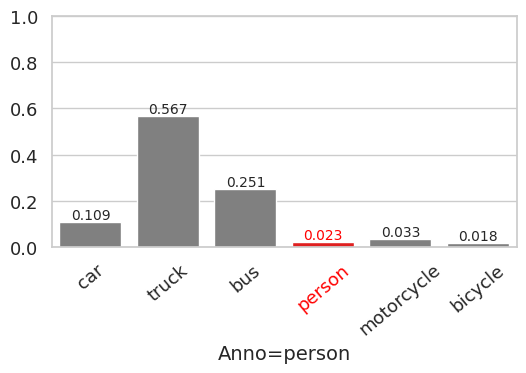

Save to /home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/COCO_gdino_swint/perclass_all_SC_uni1/6_probnll.png


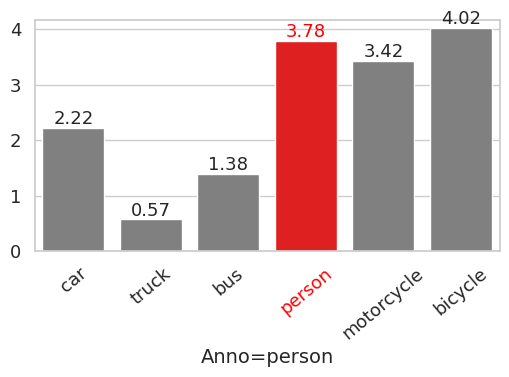

Save to /home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/COCO_gdino_swint/perclass_all_SC_uni1/6_nmnll.png


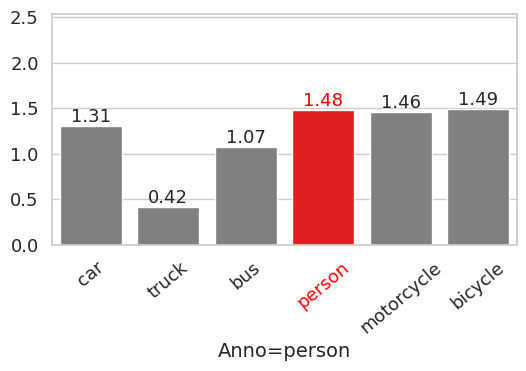

In [20]:
import warnings
warnings.filterwarnings('ignore')

m_names = ['uni20', 'ass20', 'uni10', 'ass10', 'uni5', 'ass5', 'uni1', 'ass1']
m_name = 'uni1'
epo = 1 # this is the round
start = 10
topn = 10
ranked_by = 'SC'
classname = 'all'
# classname = 'truck'
# classname = 'motorcycle'
# colnames = ["cls_score", "label_gt", "label_gt_des", "label_pred", "label_pred_des", "imgpath", "bbox_gt","prob", "CL_SC", "SC", "loss", "CL_NM", "NM"]

epo_df = m_dic[m_name][epo].copy()
if classname != 'all':
    class_df = epo_df.loc[epo_df['label_gt_des']==classname]
else:
    class_df = epo_df

# class_df = epo_df.loc[epo_df['label_gt_des']==classname]
class_df.sort_values(by=ranked_by, ascending=True, inplace=True)
class_df = class_df.iloc[start:start+topn]
print_str = class_df['imgpath'].values
print(print_str)

classes = list(id2class.values())

# print(f'{class_df["NM"]}')

# def draw_single_barplot(df, classes, yname, ylimit, colors, label_gt_des):
#     plt.figure(figsize=(6, 4))
#     colors = ['red' if cname == label_gt_des else 'gray' for cname in df['class']]
#     g=sns.barplot(df, x="class", y="nmnll", palette=colors)
#     labels_str = [f'{i:.2f}' for i in df['nmnll']]
#     # labels_str[label_gt] = f'{nmnll[label_gt]:.2f}'
#     for container in g.containers:
#         g.bar_label(container, labels=labels_str, label_type='edge')
#     ######################
#     g.set_ylim([0, ylimit])
#     g.tick_params(axis='y', labelsize=10)
#     g.tick_params(axis='x', labelsize=10)
#     plt.xticks(rotation=30, ha='center')
#     g.set_xlabel(f'Anno={label_gt_des}', fontsize=14)
#     g.set_ylabel(f'{yname}', fontsize=8)
#     plt.show()

def draw_multirow_single(topn, df, yaxis, classname, classes, fig_path):

    sns.set_theme(style="whitegrid")

    class_df['maxprob'] = class_df['prob'].apply(lambda x: np.max(x))
    class_df['probnll'] = class_df['prob'].apply(lambda x: -np.log(x))
    class_df['maxprobnll'] = class_df['probnll'].apply(lambda x: np.max(x))

    class_df['nm'] = class_df['prob'].apply(lambda x: cal_margin(x))
    class_df['nmnll'] = class_df['nm'].apply(lambda x: -np.log(x))
    class_df['maxnmnll'] = class_df['nmnll'].apply(lambda x: np.max(x))

    ylimit = None

    # pic_tuple = [2, None] # index and anno_bar
    pic_tuple = [5, None] # index and anno_bar

    for rank_i in [pic_tuple[0]]:

        item_df = class_df.iloc[rank_i]

        label_gt = item_df['label_gt']
        pic_tuple[ 1] = label_gt
        label_gt_des = item_df['label_gt_des']
        label_pred = item_df['label_pred']
        label_pred_des = item_df['label_pred_des']

        maxprob_i = item_df['maxprob']
        maxprob_i2 = class_df['maxprob'].iloc[rank_i]
        assert maxprob_i == maxprob_i2, f'maxprob_i={maxprob_i}, maxprob_i2={maxprob_i2}'

        probnll = item_df['probnll']
        maxprobnll = np.max(class_df['maxprobnll'])
        maxprobnll_i = item_df['maxprobnll']
        maxprobnll_i2 = class_df['maxprobnll'].iloc[rank_i]
        assert maxprobnll_i == maxprobnll_i2, f'maxprobnll_i={maxprobnll_i}, maxprobnll_i2={maxprobnll_i2}'

        nmnll = item_df['nmnll']
        maxnmnll = np.max(class_df['maxnmnll'])
        maxnmnll_i = item_df['maxnmnll']
        maxnmnll_i2 = class_df['maxnmnll'].iloc[rank_i]
        assert maxnmnll_i == maxnmnll_i2, f'maxnmnll_i={maxnmnll_i}, maxnmnll_i2={maxnmnll_i2}'

        d = {'probnll': item_df['probnll'], 'prob': item_df['prob'], 'class': classes, 'nmnll': item_df['nmnll']}
        df = pd.DataFrame(data=d)
        colors = ['red' if cname == label_gt_des else 'gray' for cname in df['class']]

        plt.figure(figsize=(6, 3))

        if yaxis == 'Predictive Probability':
            ylimit = 1
            yname = yaxis
            yshortname = 'prob'
            labels_str = [f'{i:.3f}' for i in df['prob']]
            g=sns.barplot(df, x="class", y="prob", palette=colors)
            barfontsize = 10


        elif yaxis == 'Self-Confidence':
            ylimit = maxprobnll
            yshortname = 'probnll'
            yname = 'Negative Log of Self-Confidence'
            labels_str = [f'{i:.2f}' for i in df['probnll']]
            g=sns.barplot(df, x="class", y="probnll", palette=colors)
            barfontsize = 13


        elif yaxis == 'Normalized Margin':
            ylimit = maxnmnll
            yshortname = 'nmnll'
            yname = 'Negative Log of Normalized Margin'
            labels_str = [f'{i:.2f}' for i in df['nmnll']]
            g=sns.barplot(df, x="class", y="nmnll", palette=colors)
            barfontsize = 13

        # hack
        red_i = pic_tuple[1]
        for container in g.containers:
            tboxes = g.bar_label(container, labels=labels_str, label_type='edge', fontsize=barfontsize)
            tboxes[red_i].set_color('red')
        ######################
        g.set_ylim([0, ylimit])
        g.tick_params(axis='y', labelsize=13)
        g.tick_params(axis='x', labelsize=13)

        plt.gca().get_xticklabels()[red_i].set_color("red")
        # plt.gca().get_xticklabels()[8].set_color("red")
        plt.xticks(rotation=40, ha='center')
        g.set_xlabel(f'Anno={label_gt_des}', fontsize=14)
        g.set_ylabel(f'')
        # g.get_ylabel().set_visible(False)
        plt.savefig(f'{fig_dirpath}/{rank_i+1}th_{yshortname}.png', dpi=80, bbox_inches="tight")
        print(f'Save to {fig_dirpath}/{rank_i+1}_{yshortname}.png')
        plt.show()



def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_max(array, value):
    return np.max(array)

def cal_margin(arr):
    margins = []
    for i, prob in enumerate(arr):

        new_arr = np.delete(arr, i)
        next_prob = find_max(new_arr, value=prob)
        margin = ((prob - next_prob) +1)/2
        margins.append(margin)
    
    # print(f'margins={margins}')
    margins = np.absolute(margins)

    return margins

def draw_multirow(topn, df, yaxis, classname, classes, fig_path):
    fig, axes = plt.subplots(nrows=1, ncols=topn, sharey=True, sharex=True, figsize=(16, 2))
    # fig, axes = plt.subplots(nrows=1, ncols=topn, sharey=True, sharex=True, figsize=(16, 2), constrained_layout=True)
    sns.set_theme(style="whitegrid")

    # fig.suptitle(f'{yaxis}', fontsize=12)


    class_df['maxprob'] = class_df['prob'].apply(lambda x: np.max(x))
    class_df['probnll'] = class_df['prob'].apply(lambda x: -np.log(x))
    class_df['maxprobnll'] = class_df['probnll'].apply(lambda x: np.max(x))

    class_df['nm'] = class_df['prob'].apply(lambda x: cal_margin(x))
    class_df['nmnll'] = class_df['nm'].apply(lambda x: -np.log(x))
    class_df['maxnmnll'] = class_df['nmnll'].apply(lambda x: np.max(x))

    ylimit = None

    for rank_i, ax in zip(range(0, topn), axes.flatten()):

        item_df = class_df.iloc[rank_i]

        true_label_des = item_df['true_label_des']
        label_gt = item_df['label_gt']
        label_gt_des = item_df['label_gt_des']
        label_pred = item_df['label_pred']
        label_pred_des = item_df['label_pred_des']

        maxprob_i = item_df['maxprob']
        maxprob_i2 = class_df['maxprob'].iloc[rank_i]
        assert maxprob_i == maxprob_i2, f'maxprob_i={maxprob_i}, maxprob_i2={maxprob_i2}'

        probnll = item_df['probnll']
        maxprobnll = np.max(class_df['maxprobnll'])
        maxprobnll_i = item_df['maxprobnll']
        maxprobnll_i2 = class_df['maxprobnll'].iloc[rank_i]
        assert maxprobnll_i == maxprobnll_i2, f'maxprobnll_i={maxprobnll_i}, maxprobnll_i2={maxprobnll_i2}'

        nmnll = item_df['nmnll']
        maxnmnll = np.max(class_df['maxnmnll'])
        maxnmnll_i = item_df['maxnmnll']
        maxnmnll_i2 = class_df['maxnmnll'].iloc[rank_i]
        assert maxnmnll_i == maxnmnll_i2, f'maxnmnll_i={maxnmnll_i}, maxnmnll_i2={maxnmnll_i2}'

        d = {'probnll': item_df['probnll'], 'prob': item_df['prob'], 'class': classes, 'nmnll': item_df['nmnll']}
        df = pd.DataFrame(data=d)
        colors = ['red' if cname == label_gt_des else 'gray' for cname in df['class']]

        if yaxis == 'Predictive Probability':
            ax.set_ylim([0, 1])
            g1 = sns.barplot(df, x="class", y="prob", ax=ax, palette=colors)

            labels_str = ['']*len(classes)
            labels_str[label_pred] = f'{maxprob_i:.3f}'
            for container in g1.containers:
                ax.bar_label(container, labels=labels_str, label_type='edge')

            ax.tick_params(axis='y', labelsize=7)
            ax.set_xlabel(label_pred_des, fontsize=14)

            # if rank_i in [4, 5]:
            #     yname = 'Predictive Probability'
            #     draw_single_barplot(df, classes,yname, ylimit, colors, label_gt_des)

        elif yaxis == 'Self-Confidence':
            ylimit = maxprobnll
            ax.set_ylim([0, ylimit])
            g2 = sns.barplot(df, x="class", y="probnll", ax=ax, palette=colors)

            ######################
            # add bar label
            labels_str = ['']*len(classes)
            labels_str[label_gt] = f'{probnll[label_gt]:.2f}'
            for container in g2.containers:
                ax.bar_label(container, labels=labels_str, label_type='edge')
            ######################
            ax.tick_params(axis='y', labelsize=9)
            ax.set_xlabel(f'True={true_label_des}\nAnno={label_gt_des}', fontsize=12)

            # if rank_i in [4, 5]:
            #     yname = 'Negative Log of Self-Confidence'
            #     draw_single_barplot(df, classes,yname, ylimit, colors, label_gt_des)


        elif yaxis == 'Normalized Margin':
            ylimit = maxnmnll
            ######################
            # add bar label
            g3=sns.barplot(df, x="class", y="nmnll", ax=ax, palette=colors)
            labels_str = ['']*len(classes)
            labels_str[label_gt] = f'{nmnll[label_gt]:.2f}'
            for container in g3.containers:
                ax.bar_label(container, labels=labels_str, label_type='edge')
            ######################
            ax.set_ylim([0, ylimit])
            ax.tick_params(axis='y', labelsize=9)
            ax.set_xlabel(f'True={true_label_des}\nAnno={label_gt_des}', fontsize=12)

            # if rank_i in [4, 5]:
            #     yname = 'Negative Log of Normalized Margin'
            #     draw_single_barplot(df, classes,yname, ylimit, colors, label_gt_des)
        
        # if rank_i < topn:
        # print(f'probnll={probnll[class2id[classname]]}, prob={prob[class2id[classname]]}, nm={nm[class2id[classname]]}')

        
        ax.set(ylabel = '')
        # ax.tick_params(axis='x', labelsize=26)
        
        # ax.get_legend().set_visible(False)
        ax.set_xticks([])
        # ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(f'{fig_path}', dpi=110)
    plt.show()

fig_dirpath = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/COCO_gdino_swint/perclass_{classname}_{ranked_by}_{m_name}'


if not os.path.isdir(fig_dirpath):
    os.makedirs(fig_dirpath, exist_ok=True)

yaxis = 'Predictive Probability'
fig_path = f'{fig_dirpath}/{classname}_prob.png'
# draw_multirow(topn, class_df, yaxis, classname, classes, fig_path)
draw_multirow_single(topn, class_df, yaxis, classname, classes, fig_dirpath)

yaxis = 'Self-Confidence'
fig_path = f'{fig_dirpath}/{classname}_SC.png'
# draw_multirow(topn, class_df, yaxis, classname, classes, fig_path)
draw_multirow_single(topn, class_df, yaxis, classname, classes, fig_dirpath)

yaxis = 'Normalized Margin'
fig_path = f'{fig_dirpath}/{classname}_NM.png'
# draw_multirow(topn, class_df, yaxis, classname, classes, fig_path)
draw_multirow_single(topn, class_df, yaxis, classname, classes, fig_dirpath)

########################################
#                     Save single bbox images
########################################
# cnt = 0
# for bbox_idx, row in class_df.iterrows():
#     img = np.array(Image.open(row['imgpath']))
#     if img.ndim ==2:
#         print(f'Convert gray image to RGB')
#         # Load the grayscale image 
#         img_gray = Image.open(row['imgpath']).convert('L') 

#         # Create a new RGB image with three identical grayscale channels 
#         img = Image.merge('RGB', [img_gray]*3)
#         img = np.array(img)
        
#     img_shape = img.shape

#     isshow = False
#     isfont = False
#     img_with_bbox = draw_bboxes(img, [row['bbox_gt']], [row['label_gt']], [row['label_gt_des']], [row['label_pred']], [row['label_pred_des']], name2RGB, name2white, isshow, isfont)

#     bbox_img = crop_bboxes(img_with_bbox, img_shape, [row['bbox_gt']], [row['label_gt']], pad=15)[0]

#     plt.imshow(bbox_img, cmap="gray")
#     plt.axis('off')
    

#     if not os.path.isdir(fig_dirpath):
#         os.makedirs(fig_dirpath, exist_ok=True)

#     # fig_dirpath = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/SHIFT_rcnn/perclass_{classname}_{ranked_by}'
#     imgname = row['imgpath'].replace('.jpg', '').replace('/', '_')

#     plt.savefig(f"{fig_dirpath}/{classname}_{cnt}_{imgname}.png", bbox_inches='tight')
    

#     # print(f'bbox_idx={bbox_idx}, classname={classname}')
#     cnt += 1

#     if cnt > topn:
#         break



#     bdd100k_det = {
#     0: "pedestrian",
#     1: "rider",
#     2: "car",
#     3: "truck",
#     4: "bus",
#     5: "train",
#     6: "motorcycle",
#     7: "bicycle",
#     8: "traffic light",
#     9: "traffic sign",
#     10: "bg",
# }

# shift_det = {
#     0: "pedestrian",
#     1: "car",
#     2: "truck",
#     3: "bus",
#     4: "motorcycle",
#     5: "bicycle",
#     6: "bg"
# }

# peak_mapper = {
#     "pedestrian": "bicycle",
#     "car": "bus",
#     "truck": "car",
#     "bus": "truck",
#     "motorcycle": "bicycle",
#     "bicycle": "motorcycle",
# }


# T-Test
# effectiveness of Confident Joint (p-values over epochs)

In [93]:
import scipy
from scipy.stats import ttest_ind, ttest_rel, combine_pvalues

# m_names = ['uni20', 'ass20', 'uni10', 'ass10', 'uni5', 'ass5', 'uni1', 'ass1']


# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/top200_patk_all.pkl'
auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/cj_patk_all.pkl'
# auc_ratk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/cj_ratk_all.pkl'

with open(auc_patk_dic_filepath, 'rb') as f:
    auc_patk_dic = pickle.load(f)

with open(auc_ratk_dic_filepath, 'rb') as f:
    auc_ratk_dic = pickle.load(f)

auc_dic = auc_patk_dic

def compare_effectiveness_cl(m_names, methods):
    t_values = []
    p_values = []

    for m_name in m_names:
        # df = perform_dic[m_name].copy()

        for (rank, cl) in methods:
            a=[i[0] for i in auc_dic[m_name][rank]['aucs']]
            b=[i[0] for i in auc_dic[m_name][cl]['aucs']]

            result = scipy.stats.ttest_rel(a, b, axis=0, alternative='two-sided')
            t_values.append(result.statistic)
            p_values.append(result.pvalue)
            # print(f'{m_name}, {cl}, {rank}, t-value={result.statistic[0]}, p-value={result.pvalue[0]}')

    # combined_pvalue = combine_pvalues(p_values,  method='fisher')
    combined_pvalue = np.average(p_values)
    # print(f'{m_name}, combined_pvalue={combined_pvalue[0]}, combined p-value={combined_pvalue[1]}')

    return t_values, p_values, combined_pvalue

def print_latex(auc_dic, m_names, methods):

    for method in methods:
        # every latex row
        
        auc_list = []
        mean_list = []
        std_list = []

        for m_name in m_names:
            auc_list =[100.0*i[0] for i in auc_dic[m_name][method]['aucs']]
            auc_mean = np.mean(auc_list)
            auc_std = np.std(auc_list, ddof=1)
            mean_list.append(auc_mean)
            std_list.append(auc_std)

        mean_list = [f'{i:.1f}' for i in mean_list]
        std_list = [f'{i:.1f}' for i in std_list]
        row_str = ' & '.join([f'{i}$\pm${j}' for i, j in zip(mean_list, std_list)])
        row_str = f'{method} & {row_str} \\\\'
        print(row_str)


######################################
#                                 Print Latex
######################################
m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
methods = ['SC', 'CL_SC', 'NM', 'CL_NM']
print_latex(auc_dic, m_names, methods)

######################################
#                 Print Latex t-values and p-values
######################################
t_list =[]
p_list = []
print(f'----- Self-Confidence uniform noise -----')
methods = [('SC', 'CL_SC')]
m_names = ['uni20', 'uni10', 'uni5', 'uni1']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_list.extend(t_values)
p_list.extend(p_values)
print(f'Combined p-value={combined_pvalue}')

print(f'----- Self-Confidence asymmetric noise -----')
methods = [('SC', 'CL_SC')]
m_names = ['ass20', 'ass10', 'ass5', 'ass1']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_list.extend(t_values)
p_list.extend(p_values)
print(f'Combined p-value={combined_pvalue}')


# print(f'----- Self-Confidence uniform+asymmetric noise -----')
# methods = [('SC', 'CL_SC')]
# m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
# t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
# print(f'Combined p-value={combined_pvalue}')

tvalue_latex = ' & '.join([f'{i:.2f}' for i in t_list])
pvalue_latex = ' & '.join([f'{i:.2f}' for i in p_list])
print(f't-values = {tvalue_latex}')
print(f'p-values = {pvalue_latex}')


print(' ')
t_list =[]
p_list = []
print(f'----- Normalized Margin uniform noise -----')
methods = [('NM', 'CL_NM')]
m_names = ['uni20', 'uni10', 'uni5', 'uni1']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_list.extend(t_values)
p_list.extend(p_values)
print(f'Combined p-value={combined_pvalue}')


print(f'----- Normalized Margin asymmetric noise -----')
methods = [('NM', 'CL_NM')]
m_names = ['ass20', 'ass10', 'ass5', 'ass1']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_list.extend(t_values)
p_list.extend(p_values)
print(f'Combined p-value={combined_pvalue}')


# print(f'----- Normalized Margin uniform+asymmetric noise -----')
# methods = [('NM', 'CL_NM')]
# m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
# t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
# print(f'Combined p-value={combined_pvalue}')



tvalue_latex = ' & '.join([f'{i:.2f}' for i in t_list])
pvalue_latex = ' & '.join([f'{i:.2f}' for i in p_list])
print(f't-values = {tvalue_latex}')
print(f'p-values = {pvalue_latex}')

SC & 97.8$\pm$0.1 & 94.9$\pm$0.3 & 90.5$\pm$0.7 & 66.9$\pm$2.2 & 96.2$\pm$0.2 & 91.6$\pm$0.3 & 84.8$\pm$0.6 & 54.2$\pm$3.7 \\
CL_SC & 95.2$\pm$0.1 & 91.2$\pm$0.6 & 87.7$\pm$0.8 & 70.0$\pm$2.5 & 94.4$\pm$0.2 & 91.0$\pm$0.3 & 86.2$\pm$0.2 & 64.6$\pm$2.3 \\
NM & 99.3$\pm$0.0 & 98.3$\pm$0.2 & 96.6$\pm$0.2 & 84.2$\pm$0.4 & 99.4$\pm$0.1 & 98.5$\pm$0.1 & 96.7$\pm$0.2 & 81.8$\pm$1.0 \\
CL_NM & 96.3$\pm$0.1 & 93.2$\pm$0.5 & 90.6$\pm$0.5 & 75.7$\pm$1.5 & 96.9$\pm$0.1 & 94.7$\pm$0.2 & 91.5$\pm$0.3 & 74.3$\pm$1.6 \\
----- Self-Confidence uniform noise -----
Combined p-value=0.000287276104530015
----- Self-Confidence asymmetric noise -----
Combined p-value=0.0008900987238401197
t-values = 57.10 & 22.79 & 18.23 & -8.45 & 18.58 & 8.66 & -6.83 & -14.53
p-values = 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00
 
----- Normalized Margin uniform noise -----
Combined p-value=3.918160754738871e-05
----- Normalized Margin asymmetric noise -----
Combined p-value=1.7853172055092673e-05
t-values = 53.98

#  Ranking Efficacy
# Normalized Margin is better

In [5]:
import scipy
from scipy.stats import ttest_ind, ttest_rel, combine_pvalues

# m_names = ['uni20', 'ass20', 'uni10', 'ass10', 'uni5', 'ass5', 'uni1', 'ass1']


# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/top200_patk_all.pkl'
auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/top2000_patk_all.pkl'
# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/cj_patk_all.pkl'
# auc_ratk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/cj_ratk_all.pkl'

with open(auc_patk_dic_filepath, 'rb') as f:
    auc_patk_dic = pickle.load(f)

# with open(auc_ratk_dic_filepath, 'rb') as f:
#     auc_ratk_dic = pickle.load(f)

auc_dic = auc_patk_dic

def compare_effectiveness_cl(m_names, methods):
    t_values = []
    p_values = []

    for m_name in m_names:
        # df = perform_dic[m_name].copy()

        for (cl, rank) in methods:
            a=auc_dic[m_name][cl]['aucs']
            b=auc_dic[m_name][rank]['aucs']

            result = scipy.stats.ttest_rel(a, b, axis=0, alternative='two-sided')
            t_values.append(result.statistic)
            p_values.append(result.pvalue)
            # print(f'{m_name}, {cl}, {rank}, t-value={result.statistic[0]}, p-value={result.pvalue[0]}')

    # combined_pvalue = combine_pvalues(p_values,  method='fisher')
    combined_pvalue = np.average(p_values)
    # print(f'{m_name}, combined_pvalue={combined_pvalue[0]}, combined p-value={combined_pvalue[1]}')

    return t_values, p_values, combined_pvalue

t_list = []
p_list = []
print(f'----- SC vs NM uniform noise -----')
methods = [('SC', 'NM')]
m_names = ['uni20', 'uni10', 'uni5', 'uni1']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_list.extend(t_values)
p_list.extend(p_values)
print(f'Combined p-value={combined_pvalue}')

print(f'----- SC vs NM asymmetric noise -----')
methods = [('SC', 'NM')]
m_names = ['ass20', 'ass10', 'ass5', 'ass1']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_list.extend(t_values)
p_list.extend(p_values)
print(f'Combined p-value={combined_pvalue}')

tvalue_latex = ' & '.join([f'{i:.2f}' for i in t_list])
pvalue_latex = ' & '.join([f'{i:.2f}' for i in p_list])
print(f't-values = {tvalue_latex}')
print(f'p-values = {pvalue_latex}')

##########################################
t_list = []
p_list = []
print(f'----- CL_SC vs CL_NM uniform noise -----')
methods = [('CL_SC', 'CL_NM')]
m_names = ['uni20', 'uni10', 'uni5', 'uni1']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_list.extend(t_values)
p_list.extend(p_values)
print(f'Combined p-value={combined_pvalue}')

print(f'----- CL_SC vs CL_NM asymmetric noise -----')
methods = [('CL_SC', 'CL_NM')]
m_names = ['ass20', 'ass10', 'ass5', 'ass1']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_list.extend(t_values)
p_list.extend(p_values)
print(f'Combined p-value={combined_pvalue}')



tvalue_latex = ' & '.join([f'{i:.2f}' for i in t_list])
pvalue_latex = ' & '.join([f'{i:.2f}' for i in p_list])
print(f't-values = {tvalue_latex}')
print(f'p-values = {pvalue_latex}')


# print(' ')
# print(f'----- Normalized Margin uniform noise -----')
# methods = [('NM', 'CL_NM')]
# m_names = ['uni20', 'uni10', 'uni5', 'uni1']
# t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
# print(f'Combined p-value={combined_pvalue}')


# print(f'----- Normalized Margin asymmetric noise -----')
# methods = [('NM', 'CL_NM')]
# m_names = ['ass20', 'ass10', 'ass5', 'ass1']
# t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
# print(f'Combined p-value={combined_pvalue}')


# print(f'----- Normalized Margin uniform+asymmetric noise -----')
# methods = [('NM', 'CL_NM')]
# m_names = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
# t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
# print(f'Combined p-value={combined_pvalue}')



# tvalue_latex = ' & '.join([f'{i:.2f}' for i in t_values])
# pvalue_latex = ' & '.join([f'{i:.2f}' for i in p_values])
# print(f't-values = {tvalue_latex}')
# print(f'p-values = {pvalue_latex}')

----- SC vs NM uniform noise -----
Combined p-value=3.177604388630021e-05
----- SC vs NM asymmetric noise -----
Combined p-value=1.2621467936128325e-06
t-values = -24.20 & -55.69 & -28.36 & -15.54 & -44.24 & -74.90 & -50.75 & -39.74
p-values = 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00
----- CL_SC vs CL_NM uniform noise -----
Combined p-value=0.00011158452848827351
----- CL_SC vs CL_NM asymmetric noise -----
Combined p-value=9.582020959296336e-06
t-values = -27.47 & -23.99 & -23.09 & -10.94 & -40.35 & -70.20 & -52.61 & -20.26
p-values = 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00


#  Correlation between Model performance and AED performance
## All epoch, to use more sample points

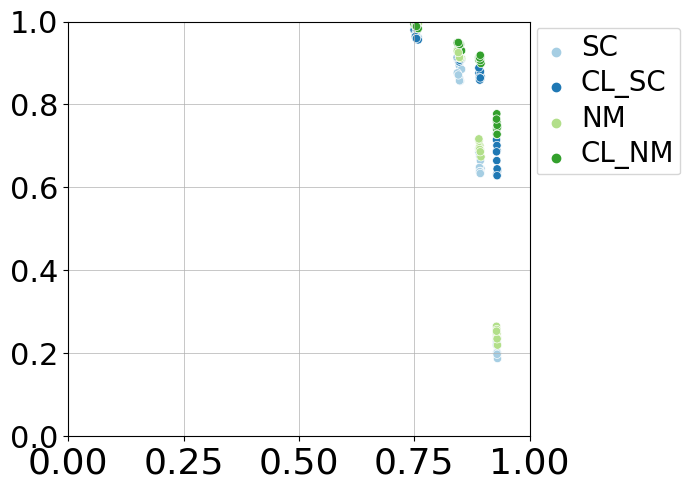

----- ('SC',) -----
Sample size = 40
pearsonr=PearsonRResult(statistic=-0.8667798091325525, pvalue=4.845695384446587e-13)
spearmanr=SignificanceResult(statistic=-0.9777652730899441, pvalue=2.1846562097148317e-27)
----- ('CL_SC',) -----
Sample size = 40
pearsonr=PearsonRResult(statistic=-0.8424720550391374, pvalue=9.369366877585692e-12)
spearmanr=SignificanceResult(statistic=-0.9721362271884477, pvalue=1.5149381200507251e-25)
----- ('NM',) -----
Sample size = 40
pearsonr=PearsonRResult(statistic=-0.8552010240961041, pvalue=2.1241789986868574e-12)
spearmanr=SignificanceResult(statistic=-0.9870531988274135, pvalue=8.158908670349592e-32)
----- ('CL_NM',) -----
Sample size = 40
pearsonr=PearsonRResult(statistic=-0.8498674681497758, pvalue=4.0220660889846545e-12)
spearmanr=SignificanceResult(statistic=-0.9632235711777447, pvalue=2.734451335428639e-23)


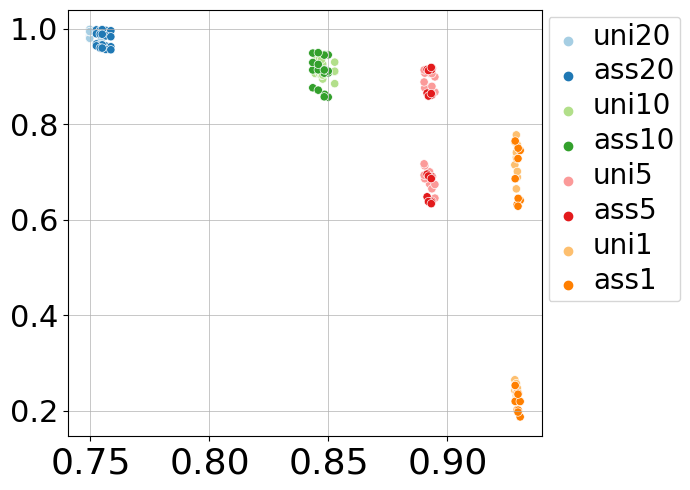


----- ('uni20', 'SC') -----
Sample size = 5
pearsonr=PearsonRResult(statistic=-0.8552805529906544, pvalue=0.06463452453562325)
spearmanr=SignificanceResult(statistic=-0.8999999999999998, pvalue=0.03738607346849874)
----- ('uni20', 'CL_SC') -----
Sample size = 5
pearsonr=PearsonRResult(statistic=-0.9946859507390085, pvalue=0.0004646497838391271)
spearmanr=SignificanceResult(statistic=-0.8999999999999998, pvalue=0.03738607346849874)
----- ('uni20', 'NM') -----
Sample size = 5
pearsonr=PearsonRResult(statistic=-0.26898122912152383, pvalue=0.6616982414403629)
spearmanr=SignificanceResult(statistic=-0.6, pvalue=0.28475697986529375)
----- ('uni20', 'CL_NM') -----
Sample size = 5
pearsonr=PearsonRResult(statistic=-0.701102131678175, pvalue=0.18711902245870396)
spearmanr=SignificanceResult(statistic=-0.7, pvalue=0.1881204043741873)
----- ('ass20', 'SC') -----
Sample size = 5
pearsonr=PearsonRResult(statistic=-0.9828318859529268, pvalue=0.0026933709534616647)
spearmanr=SignificanceResult(stati

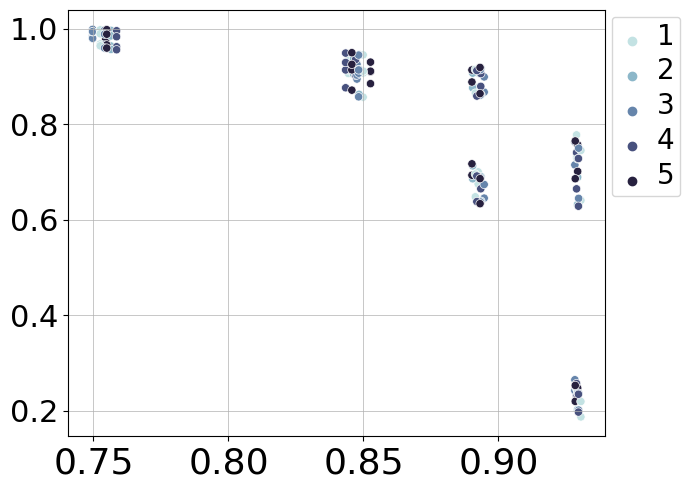


----- (1, 'SC') -----
Sample size = 8
pearsonr=PearsonRResult(statistic=-0.8655963633014021, pvalue=0.005474378097131671)
spearmanr=SignificanceResult(statistic=-0.9523809523809524, pvalue=0.00026040002438725105)
----- (1, 'CL_SC') -----
Sample size = 8
pearsonr=PearsonRResult(statistic=-0.8464267675157229, pvalue=0.008044045134197935)
spearmanr=SignificanceResult(statistic=-0.9523809523809524, pvalue=0.00026040002438725105)
----- (1, 'NM') -----
Sample size = 8
pearsonr=PearsonRResult(statistic=-0.8536411849950066, pvalue=0.007002675643159552)
spearmanr=SignificanceResult(statistic=-0.9761904761904763, pvalue=3.3143960262001043e-05)
----- (1, 'CL_NM') -----
Sample size = 8
pearsonr=PearsonRResult(statistic=-0.8618881489509949, pvalue=0.005922792240809823)
spearmanr=SignificanceResult(statistic=-0.9523809523809524, pvalue=0.00026040002438725105)
----- (2, 'SC') -----
Sample size = 8
pearsonr=PearsonRResult(statistic=-0.8623992351137564, pvalue=0.005859641941312985)
spearmanr=Significa

{(1,
  'SC'): [PearsonRResult(statistic=-0.8655963633014021, pvalue=0.005474378097131671), SignificanceResult(statistic=-0.9523809523809524, pvalue=0.00026040002438725105)],
 (1,
  'CL_SC'): [PearsonRResult(statistic=-0.8464267675157229, pvalue=0.008044045134197935), SignificanceResult(statistic=-0.9523809523809524, pvalue=0.00026040002438725105)],
 (1,
  'NM'): [PearsonRResult(statistic=-0.8536411849950066, pvalue=0.007002675643159552), SignificanceResult(statistic=-0.9761904761904763, pvalue=3.3143960262001043e-05)],
 (1,
  'CL_NM'): [PearsonRResult(statistic=-0.8618881489509949, pvalue=0.005922792240809823), SignificanceResult(statistic=-0.9523809523809524, pvalue=0.00026040002438725105)],
 (2,
  'SC'): [PearsonRResult(statistic=-0.8623992351137564, pvalue=0.005859641941312985), SignificanceResult(statistic=-0.9761904761904763, pvalue=3.3143960262001043e-05)],
 (2,
  'CL_SC'): [PearsonRResult(statistic=-0.8377348011314982, pvalue=0.009423410935100887), SignificanceResult(statistic=-

In [59]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind

m_names = ['uni20', 'ass20', 'uni10', 'ass10', 'uni5', 'ass5', 'uni1', 'ass1']
methods = ['SC', 'CL_SC', 'NM','CL_NM']
epos = list(range(1, 6))

# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/top200_patk_all.pkl'
auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/top2000_patk_all.pkl'
# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/cj_patk_all.pkl'
# auc_ratk_dic_filepath = f'./postprocessing/code/DataFrame/{coco_gdino_backbone}/aed_auc/cj_ratk_all.pkl'

columns = ['epoch', 'model_precision', 'aed_patk', 'aed_method', 'noise_pattern']


with open(auc_patk_dic_filepath, 'rb') as f:
    auc_patk_dic = pickle.load(f)

# with open(auc_ratk_dic_filepath, 'rb') as f:
#     auc_ratk_dic = pickle.load(f)

auc_dic = auc_patk_dic

precision_mi_list = []
method_auc ={m: [] for m in methods}
correlation_df = pd.DataFrame(columns=columns)

for m_name in m_names:
    model_perf_df = perform_dic[m_name].copy()

    precision_ma = model_perf_df['precision_ma'].values.tolist()
    recall_ma = model_perf_df['recall_ma'].values.tolist()
    # f1_ma = df['f1_ma'].values.tolist()

    precision_mi = model_perf_df['precision_mi'].values.tolist()
    recall_mi = model_perf_df['recall_mi'].values.tolist()
    # f1_mi = df['f1_mi'].values.tolist()

    precision_mi_list.extend(precision_mi)

    auc_result = auc_dic[m_name]

    for method in methods:
        aed_patk = auc_patk_dic[m_name][method]['aucs']
        # aed_ratk = auc_ratk_dic[m_name][method]['aucs']
        # aed_patk = [i[0] for i in aed_patk]
        # aed_ratk = [i[0] for i in aed_ratk]
        method_list = [method]*len(aed_patk)
        noise_pattern_list = [m_name]*len(aed_patk)
        epos = list(range(1, len(aed_patk)+1))

        method_auc[method].extend(method * len(aed_patk))

        row_df = pd.DataFrame(list(zip(epos, precision_mi, aed_patk, method_list, noise_pattern_list)), columns=columns)
        correlation_df = pd.concat([correlation_df, row_df], ignore_index=True)
    
    print('')



def cal_correlation(stat, model_perf_list, method_auc):
    if stat == 'spearmanr':
        sc = spearmanr(model_perf_list, method_auc['SC'], alternative='two-sided')
        cl_sc = spearmanr(model_perf_list, method_auc['CL_SC'], alternative='two-sided')
        nm = spearmanr(model_perf_list, method_auc['NM'], alternative='two-sided')
        cl_nm = spearmanr(model_perf_list, method_auc['CL_NM'], alternative='two-sided')

    elif stat == 'pearsonr':
        sc = pearsonr(model_perf_list, method_auc['SC'], alternative='two-sided')
        cl_sc = pearsonr(model_perf_list, method_auc['CL_SC'], alternative='two-sided')
        nm = pearsonr(model_perf_list, method_auc['NM'], alternative='two-sided')
        cl_nm = pearsonr(model_perf_list, method_auc['CL_NM'], alternative='two-sided')


    print(f'{stat}')
    print(f'SC={sc}')
    print(f'CL_SC={cl_sc}')
    print(f'NM={nm}')
    print(f'CL_NM={cl_nm}')


# df = pd.DataFrame({'model_precision': precision_mi_list, 'SC': method_auc['SC'], 'CL_SC': method_auc['CL_SC'], 'NM': method_auc['NM'], 'CL_NM': method_auc['CL_NM']})

# df = pd.melt(df, id_vars=['model_precision'], value_vars=['SC', 'CL_SC', 'NM', 'CL_NM'])

def draw_scatterplot(df, xaxis, yaxis, hue, is_range01):
    plt.figure(figsize=(7, 5))

    if hue == 'epoch' :
        hue_order = df['epoch'].unique().tolist()
        palette_colors = sns.color_palette("ch:start=.2,rot=-.3", len(hue_order))
        palette_dict = {l: color for l, color in zip(hue_order, palette_colors)}
        ax = sns.scatterplot(df, x=xaxis, y=yaxis, hue=hue, hue_order=hue_order, palette=palette_dict)

    elif hue == 'noise_pattern':
        hue_order = m_names
        ax = sns.scatterplot(df, x=xaxis, y=yaxis, hue=hue, hue_order=hue_order)
    else:
        ax = sns.scatterplot(df, x=xaxis, y=yaxis, hue=hue)

    if is_range01 is True:
        plt.xlim(0, 1)
        plt.ylim(0, 1)

    ax.legend(bbox_to_anchor=(1, 1))

    plt.setp(ax.get_legend().get_texts(), fontsize=20)
    ax.set(xlabel='', ylabel = '')
    ax.tick_params(axis='x', labelsize=26)
    ax.tick_params(axis='y', labelsize=22)
    # ax.get_legend().set_visible(False)

    plt.grid(linewidth = 0.5)
    plt.tight_layout()
    # plt.savefig(f'{tmp_figpath}', dpi=80)
    plt.show()
    
    category_aed_methods = pd.api.types.CategoricalDtype(categories=methods, ordered=True)
    df['aed_method'] = df['aed_method'].astype(category_aed_methods)

    grouped_df = None
    if hue == 'noise_pattern':
        category_hue = pd.api.types.CategoricalDtype(categories=m_names, ordered=True)
        df[hue] = df[hue].astype(category_hue)
        grouped_df = df.groupby([hue, 'aed_method'])
        print('')

    elif hue == 'epoch':
        category_hue = pd.api.types.CategoricalDtype(categories=list(range(1, 9)), ordered=True)
        df[hue] = df[hue].astype(category_hue)
        grouped_df = df.groupby([hue, 'aed_method'])
        print('')
    else:
        grouped_df = df.groupby([hue])


    corr_dic = {}
    for name, group in grouped_df:
        print(f'----- {name} -----')
        corr_a = group[xaxis]
        corr_b = group[yaxis]

        print(f'Sample size = {len(corr_a)}')

        pear_cc = pearsonr(corr_a, corr_b, alternative='two-sided')
        spear_cc = spearmanr(corr_a, corr_b, alternative='two-sided')
        print(f'pearsonr={pear_cc}')
        print(f'spearmanr={spear_cc}')
        corr_dic.update({name: [pear_cc, spear_cc]})

    return corr_dic



def print_latex(corr_dic, col_order, row_order):

    for row in row_order:
        print(f'----- {row} -----')
        pear_t_str = ''
        pear_p_str = ''
        spear_t_str = ''
        spear_p_str = ''

        cnt = 0
        pear_p_list = []
        spear_p_list = []

        for col in col_order:
            pear_cc = corr_dic[(col, row)][0]
            pear_t_str += f' & {pear_cc.statistic:.2f}'
            pear_p_str += f' & {pear_cc.pvalue:.2f}'
            pear_p_list.append(pear_cc.pvalue)

            spear_cc = corr_dic[(col, row)][1]
            spear_t_str += f' & {spear_cc.statistic:.2f}'
            spear_p_str += f' & {spear_cc.pvalue:.2f}'
            spear_p_list.append(spear_cc.pvalue)

            cnt+=1
            if cnt == 4:
                pear_avg = np.average(pear_p_list)
                spear_avg = np.average(spear_p_list)
                # print(f'Combined pearsonr p-value={pear_avg:.3f}')
                print(f'Combined spearmanr p-value={spear_avg:.3f}')
                pear_p_list = []
                spear_p_list = []
                cnt = 0


        # row_str += '\\\\'
        # print(f'pear_t_str={pear_t_str}')
        # print(f'pear_p_str={pear_p_str}')
        print(f'spear_t_str={spear_t_str}')
        print(f'spear_p_str={spear_p_str}')



########################################################

correlation_pair = 'precision'
# correlation_pair = 'recall'

if correlation_pair == 'precision':
    xaxis = 'model_precision'
    yaxis = 'aed_patk'
elif correlation_pair == 'recall':
    xaxis = 'model_recall'
    yaxis = 'aed_ratk'


is_range01 = True
hue = 'aed_method'
draw_scatterplot(correlation_df, xaxis, yaxis, hue, is_range01)

is_range01 = False
hue = 'noise_pattern'
corr_dic = draw_scatterplot(correlation_df, xaxis, yaxis, hue, is_range01)
col_order = ['uni20', 'uni10', 'uni5', 'uni1', 'ass20', 'ass10', 'ass5', 'ass1']
row_order = ['SC', 'CL_SC', 'NM', 'CL_NM']
print_latex(corr_dic, col_order, row_order)

is_range01 = False
hue = 'epoch'
draw_scatterplot(correlation_df, xaxis, yaxis, hue, is_range01)



# correlation_df[xaxis]

# stat = 'pearsonr'
# cal_correlation(stat, precision_mi_list, method_auc)

# stat = 'spearmanr'
# cal_correlation(stat, precision_mi_list, method_auc)


In [65]:
coco_gdino_backbone

'COCO_gdino_swint'

# Zero-shot transferbility

In [9]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind, ttest_rel





# epos = list(range(1, 6))

############################################
#                                                       swin-t
############################################
# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/COCO_gdino_swint/aed_auc/top200_patk_all.pkl'
auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/COCO_gdino_swint/aed_auc/top2000_patk_all.pkl'
# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/COCO_gdino_swint/aed_auc/cj_patk_all.pkl'
# auc_ratk_dic_filepath = f'./postprocessing/code/DataFrame/COCO_gdino_swint/aed_auc/cj_ratk_all.pkl'
patk_dic_swint = read_pkl(auc_patk_dic_filepath)

############################################
#                                                       swin-b
############################################
# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/COCO_gdino_swinb/aed_auc/top200_patk_all.pkl'
auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/COCO_gdino_swinb/aed_auc/top2000_patk_all.pkl'
# auc_patk_dic_filepath = f'./postprocessing/code/DataFrame/COCO_gdino_swinb/aed_auc/cj_patk_all.pkl'
# auc_ratk_dic_filepath = f'./postprocessing/code/DataFrame/COCO_gdino_swinb/aed_auc/cj_ratk_all.pkl'
patk_dic_swinb = read_pkl(auc_patk_dic_filepath)


m_names = ['uni20', 'uni10', 'uni5','uni1', 'ass20', 'ass10', 'ass5', 'ass1']
methods = ['SC', 'CL_SC', 'NM','CL_NM']

for method in methods:
    swint_patk = []
    swinb_patk = []
    t_list = []
    p_list = []
    diff_list = []
    for m_name in m_names:

        patk_swint = patk_dic_swint[m_name][method]['aucs']
        patk_swinb = patk_dic_swinb[m_name][method]['aucs']

        patk_swint_avg = np.average(np.array(patk_swint)*100.0)
        patk_swint_std = np.std(np.array(patk_swint)*100.0, ddof=1)
        swint_patk.append(f'{patk_swint_avg:.1f}$\pm${patk_swint_std:.1f}')

        patk_swinb_avg = np.average(np.array(patk_swinb)*100.0)
        patk_swinb_std = np.std(np.array(patk_swinb)*100.0, ddof=1)
        swinb_patk.append(f'\\textbf\u007b{patk_swinb_avg:.1f}$\pm${patk_swinb_std:.1f}\u007d')
        # swinb_patk.append(f'{patk_swinb_avg:.1f}$\pm${patk_swinb_std:.1f}')
        # patk_swint = [i[0] for i in patk_swint]
        # patk_swinb = [i[0] for i in patk_swinb]

        diff = [i - j for i, j in zip(patk_swint, patk_swinb)]
        diff_avg = np.average(diff)
        diff_std = np.std(diff, ddof=1)

        diff_list.append(f'{diff_avg:.2f}$\pm${diff_std:.2f}')

        # result = ttest_ind(patk_swint, patk_swinb, axis=0, alternative='two-sided')
        result =  ttest_rel(patk_swint, patk_swinb, axis=0, alternative='two-sided')

        t_list.append(result.statistic)
        p_list.append(result.pvalue)
    
    swint_str = ' & '.join([i for i in swint_patk])
    swinb_str = ' & '.join([i for i in swinb_patk])
    t_str = ' & '.join([f'{i:.2f}' for i in t_list])
    p_str = ' & '.join([f'\\textbf\u007b{i:.2f}\u007d' for i in p_list])

    print(f'GDINO-T  & {swint_str} \\\\')
    print(f'GDINO-B  & {swinb_str} \\\\')
    print(f't-value & {t_str} \\\\')
    print(f'p-value & {p_str} \\\\\\arrayrulecolor\u007bblack!30\u007d\midrule')
    # print('-------')
        
    diff_str = ' & '.join([i for i in diff_list])
    print(f'{method} & diff_str & {diff_str} \\\\')
    print('-----')




GDINO-T  & 98.3$\pm$0.1 & 89.8$\pm$0.9 & 67.3$\pm$1.9 & 23.0$\pm$0.8 & 96.5$\pm$0.2 & 86.5$\pm$0.9 & 63.9$\pm$0.5 & 20.2$\pm$1.2 \\
GDINO-B  & \textbf{99.9$\pm$0.0} & \textbf{94.5$\pm$0.7} & \textbf{72.1$\pm$1.8} & \textbf{26.6$\pm$1.1} & \textbf{99.9$\pm$0.0} & \textbf{94.2$\pm$0.7} & \textbf{71.4$\pm$0.5} & \textbf{25.2$\pm$1.1} \\
t-value & -37.72 & -46.11 & -33.79 & -17.28 & -29.81 & -80.40 & -74.38 & -23.89 \\
p-value & \textbf{0.00} & \textbf{0.00} & \textbf{0.00} & \textbf{0.00} & \textbf{0.00} & \textbf{0.00} & \textbf{0.00} & \textbf{0.00} \\\arrayrulecolor{black!30}\midrule
SC & diff_str & -0.02$\pm$0.00 & -0.05$\pm$0.00 & -0.05$\pm$0.00 & -0.04$\pm$0.00 & -0.03$\pm$0.00 & -0.08$\pm$0.00 & -0.08$\pm$0.00 & -0.05$\pm$0.00 \\
-----
GDINO-T  & 97.8$\pm$0.2 & 91.2$\pm$0.6 & 87.7$\pm$0.8 & 70.0$\pm$2.5 & 95.9$\pm$0.3 & 91.0$\pm$0.3 & 86.2$\pm$0.2 & 64.6$\pm$2.3 \\
GDINO-B  & \textbf{99.9$\pm$0.0} & \textbf{98.1$\pm$0.1} & \textbf{97.2$\pm$0.1} & \textbf{88.1$\pm$0.6} & \textbf{99.

In [63]:
# tmp_df = aed_perf['all'][test_mname].copy()
tmp_df = aed_perf['byclass'][test_mname].copy()
conds = (tmp_df['Method']=='CL_NM')
tmp_df.loc[conds, :]
# tmp_df

# for row, row_new in zip(tmp_df.loc[conds, :].iterrows(), cal_byclass_dic['uni1']):
#     if row[1]['Class'] = row_new[1]['Class']
#     print(row[1]['Class'], row[1]['Precision'], row[1]['Recall'])

,Method,Class,TP_all,FP_all,Precision,Recall,TP10,FP10,P@10,TP100,FP100,P@100,TP1000,FP1000,P@1000
0,CL_NM,pedestrian,169,23809,0.704813,100.0,0,10,0.0,2,98,2.0,12,988,1.2
1,CL_NM,car,212,35187,0.598887,100.0,4,6,40.0,19,81,19.0,58,942,5.8
2,CL_NM,truck,337,9879,3.298747,100.0,6,4,60.0,37,63,37.0,144,856,14.4
3,CL_NM,bus,318,4428,6.700379,100.0,10,0,100.0,52,48,52.0,165,835,16.5
4,CL_NM,motorcycle,354,7393,4.569511,100.0,2,8,20.0,9,91,9.0,77,923,7.7
5,CL_NM,bicycle,303,4052,6.957520,100.0,1,9,10.0,2,98,2.0,52,948,5.2


# Save AED Performance: cal_dic and cal_byclass_dic

In [37]:
# import pickle

# def save_pkl(obj, filepath):
#     with open(filepath, 'wb') as f:
#         pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# def read_pkl(filepath):
#     with open(filepath, 'rb') as f:
#         data = pickle.load(f)
#     return data

# aed_perf_dirpath = './postprocessing/code/DataFrame/SHIFT_gdino_cog/aed_perf'

# aed_perf_obj = {
#     'all': cal_dic,
#     'byclass': cal_byclass_dic
# }

# aed_perf_filename = f'aed_perf_{subset}'
# aed_perf_filepath = f'{aed_perf_dirpath}/aed_perf_{subset}.pkl'

# save_pkl(aed_perf_obj, aed_perf_filepath)
# # aed_perf = read_pkl(aed_perf_filepath)

# # Update the LRank
# # for m_nmea in m_names:
# #     tmp_df = aed_perf['all']['uni1']
# #     conds = (tmp_df['Method']=='LRank')
# #     tmp_df.loc[conds, :]

# #     aed_perf['all'][m_name]['LRank'] = cal_dic[m_name]['LRank']
# #     # aed_perf['byclass'][m_name] = cal_byclass_dic[m_name]['LRank']

In [38]:
tmp_df = cal_dic['ass1']
# tmp_df = cal_byclass_dic['ass1']

tmp_df.loc[:, ['Method','Class','P@10', 'P@100', 'P@1000']].head(30)

,Method,Class,P@10,P@100,P@1000
0,LRank,all,0.0,8.0,7.6
1,CL_SC,all,0.0,8.0,7.6
2,NM,all,20.0,14.0,11.2
3,CL_NM,all,20.0,14.0,11.2


In [8]:
tmp_df = cal_byclass_dic['ass1']

tmp_df.loc[:, ['Method','Class','P@10', 'P@100', 'P@1000']].head(30)

,Method,Class,P@10,P@100,P@1000
0,CL_NM,pedestrian,0.0,0.0,0.0
1,CL_NM,car,0.0,0.0,0.3
2,CL_NM,truck,0.0,1.0,0.6
3,CL_NM,bus,50.0,44.0,24.3
4,CL_NM,motorcycle,0.0,5.0,1.9
5,CL_NM,bicycle,20.0,14.0,13.8
6,CL_SC,pedestrian,0.0,0.0,0.0
7,CL_SC,car,0.0,0.0,0.1
8,CL_SC,truck,0.0,1.0,0.5
9,CL_SC,bus,0.0,31.0,25.9


In [34]:
nm_df = m_dic['ass1'].copy()
nm_df = nm_df.sort_values(by=['CL_SConf'], ascending=True)

nm_df.loc[nm_df['label_gt_des']=='bicycle', ['true_label_des','label_gt_des', 'c_incorrect','CL_NMargin', 'CL_SConf']].head(10)

,true_label_des,label_gt_des,c_incorrect,CL_NMargin,CL_SConf
84873,pedestrian,bicycle,True,0,263
68633,pedestrian,bicycle,True,1,627
18120,bicycle,bicycle,False,9496,654
74982,pedestrian,bicycle,True,118,709
75190,bicycle,bicycle,False,16401,757
209179,pedestrian,bicycle,True,57,923
18130,bicycle,bicycle,False,7548,1090
195962,bicycle,bicycle,False,11044,1136
142148,pedestrian,bicycle,True,37,1323
191497,bicycle,bicycle,False,14,1439


# Confident Learning Q and C matrix

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.special import softmax
from matplotlib.colors import LogNorm, Normalize
import math

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
pd.options.mode.chained_assignment = None  # default='warn'


def gen_heat(mat, q_mat, toptitle, title1, title2, fig_filepath, fmt1, fmt2, islog=True):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12, 4))
    fig.suptitle(toptitle, fontsize=16)


    cell_fontsize = 14
    xtick_fontsize = 14
    ytick_fontsize = 14
    # sns.set_color_codes("pastel")
    # sns.set(font_scale=1.4)
    if islog:
        g1 = sns.heatmap(mat, ax=ax1, annot=True, linewidth=.5, fmt=fmt1, cmap="Blues", xticklabels=id2class.values(), yticklabels=id2class.values(), norm=LogNorm(), annot_kws={"size": cell_fontsize})
    else:
        g1 = sns.heatmap(mat, ax=ax1, annot=True, linewidth=.5, fmt=fmt1, cmap="Blues", xticklabels=id2class.values(), yticklabels=id2class.values(), norm=Normalize(), annot_kws={"size": cell_fontsize})
    g1.set_title(title1, fontdict={'size': 12})
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30, fontsize=xtick_fontsize)
    g1.set_yticklabels(g1.get_yticklabels(), fontsize=ytick_fontsize)
    g1.collections[0].colorbar.ax.tick_params(labelsize=8)

    # q_mat = mat / np.sum(mat)
    # q_mat = estimate_joint

    if q_mat is not None:
        g2 = sns.heatmap(q_mat, ax=ax2, annot=True, linewidth=.5, fmt=fmt2, cmap="Blues", xticklabels=id2class.values(), yticklabels=id2class.values(), norm=LogNorm(), annot_kws={"size": cell_fontsize})
        # , mask=np.eye(6)
        # , norm=LogNorm()
        g2.set_title(title2, fontdict={'size': 12})
        g2.set_xticklabels(g2.get_xticklabels(), rotation=30, fontsize=xtick_fontsize)
        g2.set_yticklabels(g2.get_yticklabels(), fontsize=ytick_fontsize)
        g2.collections[0].colorbar.ax.tick_params(labelsize=8)

    
    fig.tight_layout(pad=1.0)
    plt.savefig(f'{fig_filepath}', bbox_inches='tight', dpi=300)
    plt.show()




def gen_plain_c_mat(labels_true, labels_gt, id2class):

    c_mat = np.zeros((len(id2class), len(id2class)))

    for true_label, label_gt in zip(labels_true, labels_gt):
        c_mat[true_label][label_gt] += 1

    return c_mat



def gen_one_hot(labels):
    n_values = np.max(labels) + 1
    return np.eye(n_values)[labels]


fig_dirpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig_coco_gdino_swint'

epo = 1
m_names = ['uni20', 'ass20', 'uni10', 'ass10', 'uni5', 'ass5', 'uni1', 'ass1']
# m_names = ['uni20']

for m_name in m_names:
    df = m_dic[m_name][epo]

    true_labels = df['true_label'].to_numpy()
    labels_gt = df['label_gt'].to_numpy()
    probs_true = gen_one_hot(true_labels)
    probs_gt = gen_one_hot(labels_gt)

    # c_mat_true = compute_confident_joint(true_labels, probs_true)
    c_mat_gt = compute_confident_joint(labels_gt, probs_true)
    # c_mat_gt_my = gen_plain_c_mat(labels_gt, true_labels, id2class)
    q_mat_gt = estimate_joint(labels_gt, probs_true, confident_joint=c_mat_gt)
    # True, latent SUM np.sum(c_mat_gt, axis=0)
    # flipped, observed SUM np.sum(c_mat_gt, axis=1)

    # using observed labels and predicted probabilities
    # Only accessiable when the true labels are known (SHIFT dataset)
    prior_true, noise_mat_true, inverse_noise_mat_true, c_mat_true = estimate_py_and_noise_matrices_from_probabilities(true_labels, probs_true)

    # Not necessary to use 
    # prior_gt, noise_mat_gt, inverse_noise_mat_gt, c_mat_gt = estimate_py_and_noise_matrices_from_probabilities(true_labels, probs_gt)

    # This is the my correct noise transition matrix
    prior_gt2, noise_mat_gt2, inverse_noise_mat_gt2, c_mat_gt2 = estimate_py_and_noise_matrices_from_probabilities(labels_gt, probs_true)

    q_mat_gt_my = c_mat_gt / np.sum(c_mat_gt)
    assert q_mat_gt_my.all() == q_mat_gt.all()
    toptitle = f'Noise Type: {m_name}'
    title1 = 'Ideal C matrix'
    title2 = 'Ideal Q matrix (%)'
    fmt1 = 'g'
    fmt2 = '.2f'
    _ = gen_heat(c_mat_gt, 100*q_mat_gt, toptitle, title1, title2, f'{fig_dirpath}/{m_name}_ideal_C_and_Q.png', fmt1, fmt2)

    probs = np.stack(df['prob'].to_numpy(), axis=0)[:, :]

    c_mat = compute_confident_joint(labels_gt, probs)

    q_mat = estimate_joint(labels_gt, probs, confident_joint=c_mat)
    toptitle = f'Noise Type: {m_name}'
    title1 = 'Estimated C matrix (Confident Joint)'
    title2 = 'Estimated Q matrix (%)'
    fmt1 = 'g'
    fmt2 = '.2f'
    _ = gen_heat(c_mat, 100*q_mat, toptitle, title1, title2, f'{fig_dirpath}/{m_name}_estimated_C_and_Q.png', fmt1, fmt2)


    prior, noise_mat, inverse_noise_mat, c_mat = estimate_py_and_noise_matrices_from_probabilities(labels_gt, probs)
    toptitle = f'Noise Type: {m_name}, Noise Transition Matrix (%)'
    title1 = 'Ideal'
    title2 = 'Estimated'
    fmt1 = '.2f'
    fmt2 = '.2f'
    _ = gen_heat(100*noise_mat_gt2, 100*noise_mat, toptitle, title1, title2, f'{fig_dirpath}/{m_name}_noise_transition.png', fmt1, fmt2)

    MSE = mean_squared_error(q_mat_gt, q_mat)
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n")
    print(RMSE)
    print(f'------------------------------------')
    
    
    c_diff_mat =  c_mat - c_mat_gt
    q_diff_mat =  q_mat - q_mat_gt
    top_title = f'Noise Type: {m_name}, Difference between Ideal and Estimated Q matrix (%)'
    fmt1 = 'g'
    fmt2 = '.2f'
    _ = gen_heat(c_diff_mat, 100*q_diff_mat, top_title, 'Difference', None, f'{fig_dirpath}/{m_name}_diff.png', fmt1, fmt2, islog=False)
# cj_mat = compute_confident_joint(labels_gt, probs)
# gen_heat(cj_mat, 'Confident Joint')

# cali_mat = calibrate_confident_joint(cj_mat, labels_gt)
# gen_heat(cali_mat, 'Calibrated Confident Joint')


# es_mat = estimate_joint(labels_gt, probs) * 100
# gen_heat(es_mat, 'Estimated Joint')

# py, noise_matrix, inverse_noise_matrix, confident_joint = estimate_py_and_noise_matrices_from_probabilities(labels_gt, probs)
# print('Noise Matrix: \n', noise_matrix)
# gen_heat(noise_matrix, 'Noise Matrices')